시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [26]:
#!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [27]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [28]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [29]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [30]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서
child_cctv_df

,동,어린이CCTV설치대수
0,대명동,26
1,이천동,6
2,봉덕동,8
3,가창면,8
4,구지면,6
...,...,...
67,대신동,2
68,삼덕동2가,1
69,남일동,1
70,덕산동,1


In [31]:
#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64
(10963, 15)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64


In [32]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라
print(cctv_df['동'].unique())
print(train_df['동'].unique())

[ 4  1  2 99]
['대명동' '봉덕동' '이천동' '하빈면' '다사읍' '옥포읍' '구지면' '가창면' '현풍읍' '화원읍' '논공읍' '유가읍'
 '하리' '정대리' '용계리' '유가면' '현풍면' '남리' '세천리' '매곡리' '삼산리' '북리' '호림동' '용산동'
 '월암동' '호산동' '본리동' '월성동' '송현동' '이곡동' '장기동' '대천동' '신당동' '대곡동' '진천동' '상인동'
 '감삼동' '본동' '성당동' '유천동' '죽전동' '두류동' '도원동' '파호동' '남산동' '동산동' '공평동' '삼덕동2가'
 '봉산동' '동성로3가' '남일동' '문화동' '수동' '동인동3가' '대신동' '대봉동' '수창동' '대안동' '삼덕동3가'
 '동인동4가' '종로2가' '태평로1가' '삼덕동1가' '동성로2가' nan '종로1가' '북성로1가' '북성로2가' '서야동'
 '인교동' '계산동2가' '금호동' '미곡동' '팔달동' '범어동' '신천동' '지저동' '황금동' '봉무동' '내당동' '비산동'
 '수성동1가' '고모동' '만촌동' '도학동' '국우동' '태전동' '대현동' '파동' '범물동' '평광동' '도동' '덕곡동'
 '중동' '갈산동' '두산동' '율하동' '신평동' '평리동' '중리동' '침산동' '복현동' '산격동' '신매동' '조야동'
 '율암동' '서변동' '신서동' '입석동' '효목동' '평리4동' '매천동' '읍내동' '사복동' '신암동' '구암동' '지묘동'
 '노원동3가' '삼덕동' '신암4동' '백안동' '군위읍' '이현동' '신암1동' '비산2.3동' '지산동' '두류1.2동'
 '칠성동1가' '침산2동' '비산4동' '가천동' '상동' '시지동' '서성로2가' '태평로3가' '칠성동2가' '방촌동'
 '관음동' '부계면' '신기동' '수성동4가' '효령면' '노원동1가' '동인동2가' '노원동2가' '각산동' '신안동' '학정동'
 '괴전동' '동천동' '의흥면' '우보면' '미대동' '소보면' '상리동

In [33]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서
cctv_list

,동,CCTV개수
0,대명동,27
1,봉덕동,9
2,이천동,4
3,하빈면,12
4,다사읍,52
...,...,...
168,서성로1가,1
169,중대동,2
170,삼국유사면,1
171,부동,1


In [34]:
#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(train_df['CCTV개수'].mean())
print(train_df.isnull().sum())

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(train_df['CCTV개수'].mean())
print(test_df.isnull().sum())

(39609, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64
(10963, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [35]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [36]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [37]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


In [40]:
from sklearn.preprocessing import MinMaxScaler

feature_std = ['ECLO','어린이CCTV설치대수','CCTV개수']

scaler = MinMaxScaler()
train_df[feature_std] = scaler.fit_transform(train_df[feature_std])
train_df


,ID,요일,기상상태,노면상태,사고유형,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,0.054795,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,0.033333,0.019231
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,0.027397,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,0.000000,0.076923
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,0.027397,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,0.083333,0.076923
3,ACCIDENT_00003,화요일,맑음,건조,차대차,0.054795,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,0.183333,0.192308
4,ACCIDENT_00004,화요일,맑음,건조,차대차,0.027397,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,0.000000,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,0.027397,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안,0.016667,0.019231
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,0.027397,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타,0.000000,0.346154
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,0.123288,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안,0.000000,0.173077
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,0.027397,2021,12,31,22,대구광역시,달서구,장동,기타,기타,0.000000,0.019231


In [41]:
test_std = ['어린이CCTV설치대수','CCTV개수']
test_df[test_std ] = scaler.fit_transform(test_df[test_std ])

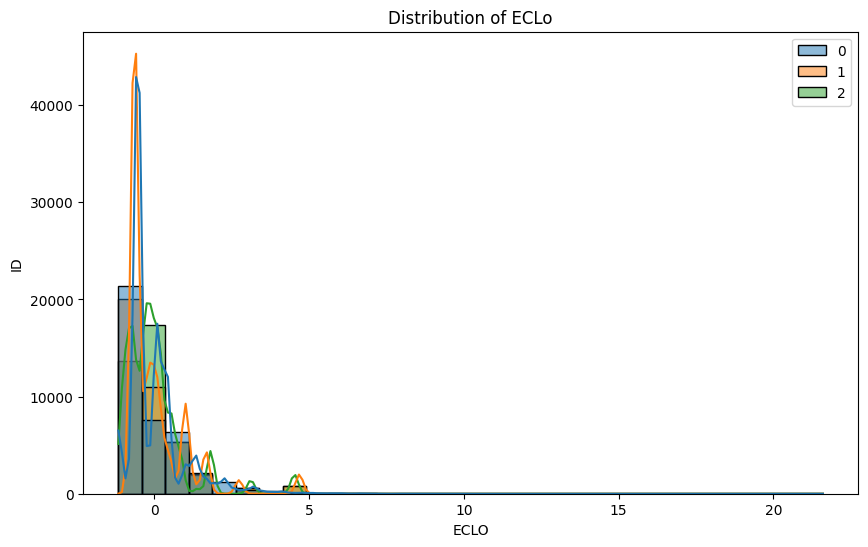

In [42]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

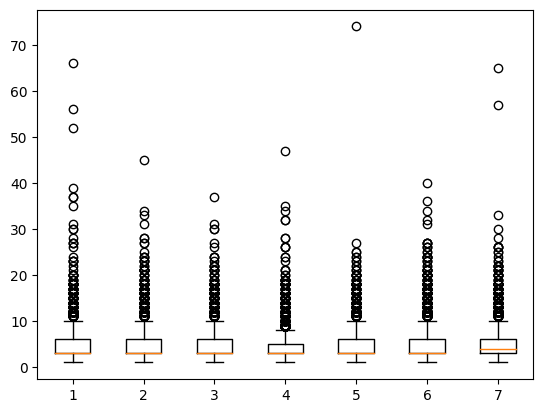

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

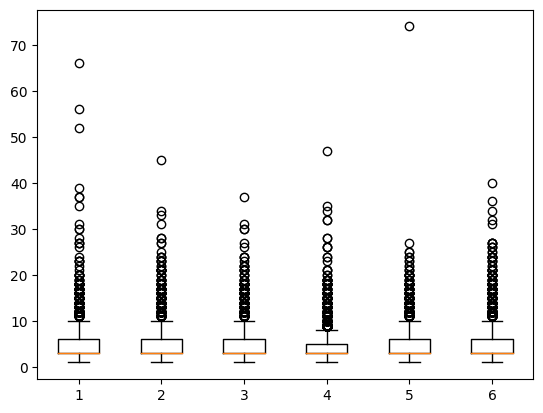

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

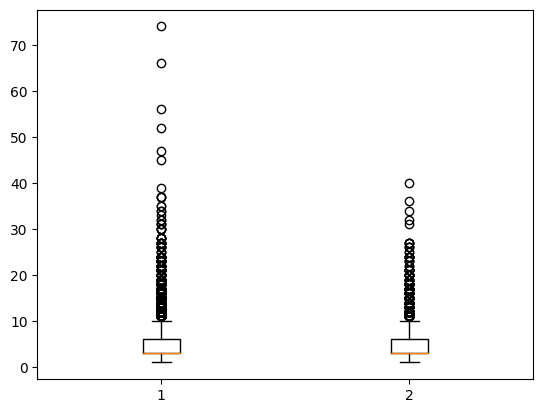

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

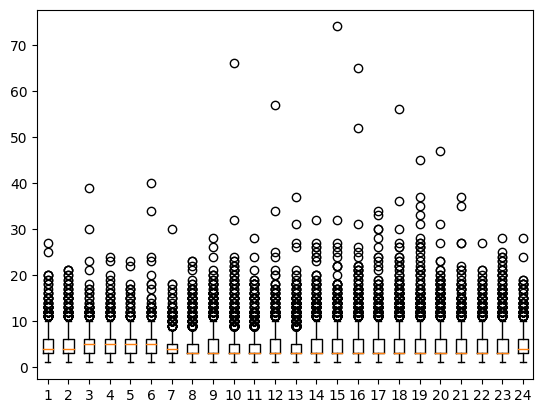

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

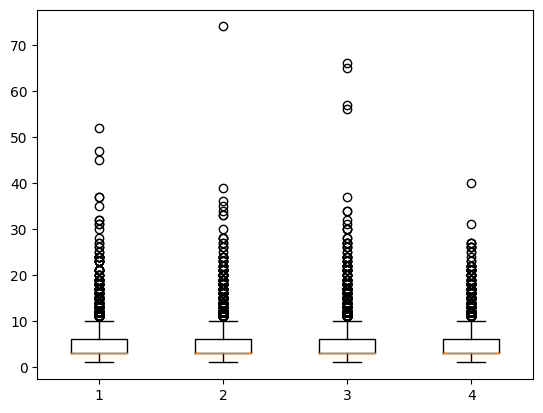

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [43]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 15) (39609,) (10963, 15)


In [44]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,0.033333,0.019231
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,0.000000,0.076923
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,0.083333,0.076923
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,0.183333,0.192308
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,0.000000,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,0,6,118,0,3,0.016667,0.019231
39605,0,2,0,1,2021,12,31,19,0,1,103,2,5,0.000000,0.346154
39606,0,2,0,1,2021,12,31,21,0,1,144,0,3,0.000000,0.173077
39607,0,2,0,1,2021,12,31,22,0,1,158,1,5,0.000000,0.019231


In [45]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,0.083333,0.076923
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,0.166667,0.134615
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,0.016667,0.019231
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,0.116667,0.211538
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,0.000000,0.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,0,38,2,9,0.433333,0.519231
10959,5,2,0,1,2022,12,31,18,0,6,123,2,5,0.083333,0.076923
10960,5,2,0,1,2022,12,31,20,0,6,134,2,5,0.000000,0.195993
10961,5,2,0,1,2022,12,31,20,0,6,77,0,2,0.116667,0.134615


모델 훈련 및 예측

In [46]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-18 12:32:43,632] A new study created in memory with name: no-name-da0ddab2-a84d-46ed-929c-96ecfeec2a52


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03559
[6]	validation_0-rmsle:0.03557
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03554
[9]	validation_0-rmsle:0.03550
[10]	validation_0-rmsle:0.03546
[11]	validation_0-rmsle:0.03545
[12]	validation_0-rmsle:0.03542
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03539
[15]	validation_0-rmsle:0.03538
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03537
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03535
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03533
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03531
[25]	validation_0-rmsle:0.03529
[26]	validation_0-rmsle:0.03528
[27]	validation_0-rmsle:0.03528
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03526
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:32:45,633] Trial 0 finished with value: 0.038405170684433866 and parameters: {'lambda': 0.031651993975796384, 'alpha': 0.9582588026927304, 'colsample_bytree': 0.5084618524633603, 'subsample': 0.504299646358001, 'learning_rate': 0.0760435919964996, 'n_estimators': 710, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 0 with value: 0.038405170684433866.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03570
[2]	validation_0-rmsle:0.03561
[3]	validation_0-rmsle:0.03555
[4]	validation_0-rmsle:0.03551
[5]	validation_0-rmsle:0.03546
[6]	validation_0-rmsle:0.03541
[7]	validation_0-rmsle:0.03537
[8]	validation_0-rmsle:0.03534
[9]	validation_0-rmsle:0.03531
[10]	validation_0-rmsle:0.03530
[11]	validation_0-rmsle:0.03527
[12]	validation_0-rmsle:0.03526
[13]	validation_0-rmsle:0.03525
[14]	validation_0-rmsle:0.03524
[15]	validation_0-rmsle:0.03524
[16]	validation_0-rmsle:0.03523
[17]	validation_0-rmsle:0.03522
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:32:47,628] Trial 1 finished with value: 0.03840525622744004 and parameters: {'lambda': 0.06875115508625083, 'alpha': 0.7384887729897279, 'colsample_bytree': 0.7207153642786207, 'subsample': 0.8339667144898826, 'learning_rate': 0.09620471966185686, 'n_estimators': 806, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 0 with value: 0.038405170684433866.


[0]	validation_0-rmsle:0.03583
[1]	validation_0-rmsle:0.03583
[2]	validation_0-rmsle:0.03582
[3]	validation_0-rmsle:0.03581
[4]	validation_0-rmsle:0.03580
[5]	validation_0-rmsle:0.03580
[6]	validation_0-rmsle:0.03579
[7]	validation_0-rmsle:0.03579
[8]	validation_0-rmsle:0.03578
[9]	validation_0-rmsle:0.03577
[10]	validation_0-rmsle:0.03576
[11]	validation_0-rmsle:0.03576
[12]	validation_0-rmsle:0.03575
[13]	validation_0-rmsle:0.03574
[14]	validation_0-rmsle:0.03573
[15]	validation_0-rmsle:0.03573
[16]	validation_0-rmsle:0.03573
[17]	validation_0-rmsle:0.03572
[18]	validation_0-rmsle:0.03572
[19]	validation_0-rmsle:0.03571
[20]	validation_0-rmsle:0.03571
[21]	validation_0-rmsle:0.03570
[22]	validation_0-rmsle:0.03570
[23]	validation_0-rmsle:0.03569
[24]	validation_0-rmsle:0.03568
[25]	validation_0-rmsle:0.03568
[26]	validation_0-rmsle:0.03567
[27]	validation_0-rmsle:0.03567
[28]	validation_0-rmsle:0.03566
[29]	validation_0-rmsle:0.03566
[30]	validation_0-rmsle:0.03565
[31]	validation_0-

[I 2023-11-18 12:32:57,272] Trial 2 finished with value: 0.03838832146430102 and parameters: {'lambda': 0.04965604379100629, 'alpha': 0.7496748744096698, 'colsample_bytree': 0.5222428220540918, 'subsample': 0.517469791695351, 'learning_rate': 0.010890964783094577, 'n_estimators': 863, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 2 with value: 0.03838832146430102.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03563
[3]	validation_0-rmsle:0.03557
[4]	validation_0-rmsle:0.03553
[5]	validation_0-rmsle:0.03548
[6]	validation_0-rmsle:0.03544
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03534
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:32:59,188] Trial 3 finished with value: 0.03837893157818587 and parameters: {'lambda': 0.005948161605134209, 'alpha': 0.7766969074832245, 'colsample_bytree': 0.7573559314866541, 'subsample': 0.7694625612065736, 'learning_rate': 0.09112898795208219, 'n_estimators': 682, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 3 with value: 0.03837893157818587.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03572
[3]	validation_0-rmsle:0.03570
[4]	validation_0-rmsle:0.03566
[5]	validation_0-rmsle:0.03564
[6]	validation_0-rmsle:0.03562
[7]	validation_0-rmsle:0.03561
[8]	validation_0-rmsle:0.03559
[9]	validation_0-rmsle:0.03555
[10]	validation_0-rmsle:0.03552
[11]	validation_0-rmsle:0.03551
[12]	validation_0-rmsle:0.03548
[13]	validation_0-rmsle:0.03548
[14]	validation_0-rmsle:0.03545
[15]	validation_0-rmsle:0.03544
[16]	validation_0-rmsle:0.03544
[17]	validation_0-rmsle:0.03543
[18]	validation_0-rmsle:0.03542
[19]	validation_0-rmsle:0.03541
[20]	validation_0-rmsle:0.03541
[21]	validation_0-rmsle:0.03540
[22]	validation_0-rmsle:0.03538
[23]	validation_0-rmsle:0.03537
[24]	validation_0-rmsle:0.03536
[25]	validation_0-rmsle:0.03535
[26]	validation_0-rmsle:0.03534
[27]	validation_0-rmsle:0.03534
[28]	validation_0-rmsle:0.03533
[29]	validation_0-rmsle:0.03532
[30]	validation_0-rmsle:0.03531
[31]	validation_0-

[I 2023-11-18 12:33:00,986] Trial 4 finished with value: 0.03840367540342556 and parameters: {'lambda': 0.04207762545809479, 'alpha': 0.297917415737287, 'colsample_bytree': 0.5162146143239054, 'subsample': 0.5235742910443403, 'learning_rate': 0.05252354956762335, 'n_estimators': 647, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 3 with value: 0.03837893157818587.


[0]	validation_0-rmsle:0.03583
[1]	validation_0-rmsle:0.03582
[2]	validation_0-rmsle:0.03580
[3]	validation_0-rmsle:0.03579
[4]	validation_0-rmsle:0.03577
[5]	validation_0-rmsle:0.03577
[6]	validation_0-rmsle:0.03576
[7]	validation_0-rmsle:0.03575
[8]	validation_0-rmsle:0.03574
[9]	validation_0-rmsle:0.03573
[10]	validation_0-rmsle:0.03571
[11]	validation_0-rmsle:0.03570
[12]	validation_0-rmsle:0.03568
[13]	validation_0-rmsle:0.03568
[14]	validation_0-rmsle:0.03566
[15]	validation_0-rmsle:0.03565
[16]	validation_0-rmsle:0.03565
[17]	validation_0-rmsle:0.03564
[18]	validation_0-rmsle:0.03564
[19]	validation_0-rmsle:0.03563
[20]	validation_0-rmsle:0.03562
[21]	validation_0-rmsle:0.03562
[22]	validation_0-rmsle:0.03560
[23]	validation_0-rmsle:0.03559
[24]	validation_0-rmsle:0.03558
[25]	validation_0-rmsle:0.03557
[26]	validation_0-rmsle:0.03556
[27]	validation_0-rmsle:0.03555
[28]	validation_0-rmsle:0.03555
[29]	validation_0-rmsle:0.03554
[30]	validation_0-rmsle:0.03553
[31]	validation_0-

[I 2023-11-18 12:33:10,655] Trial 5 finished with value: 0.038364461427781944 and parameters: {'lambda': 0.012489543895598861, 'alpha': 0.19092448080502522, 'colsample_bytree': 0.5417428085254992, 'subsample': 0.5872693172717256, 'learning_rate': 0.01720254842367323, 'n_estimators': 784, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03582
[1]	validation_0-rmsle:0.03581
[2]	validation_0-rmsle:0.03579
[3]	validation_0-rmsle:0.03577
[4]	validation_0-rmsle:0.03575
[5]	validation_0-rmsle:0.03574
[6]	validation_0-rmsle:0.03572
[7]	validation_0-rmsle:0.03571
[8]	validation_0-rmsle:0.03571
[9]	validation_0-rmsle:0.03568
[10]	validation_0-rmsle:0.03567
[11]	validation_0-rmsle:0.03565
[12]	validation_0-rmsle:0.03563
[13]	validation_0-rmsle:0.03563
[14]	validation_0-rmsle:0.03561
[15]	validation_0-rmsle:0.03561
[16]	validation_0-rmsle:0.03560
[17]	validation_0-rmsle:0.03559
[18]	validation_0-rmsle:0.03558
[19]	validation_0-rmsle:0.03557
[20]	validation_0-rmsle:0.03557
[21]	validation_0-rmsle:0.03556
[22]	validation_0-rmsle:0.03555
[23]	validation_0-rmsle:0.03553
[24]	validation_0-rmsle:0.03552
[25]	validation_0-rmsle:0.03551
[26]	validation_0-rmsle:0.03550
[27]	validation_0-rmsle:0.03549
[28]	validation_0-rmsle:0.03548
[29]	validation_0-rmsle:0.03547
[30]	validation_0-rmsle:0.03547
[31]	validation_0-

[I 2023-11-18 12:33:15,042] Trial 6 finished with value: 0.03839879159566933 and parameters: {'lambda': 0.018888691558676902, 'alpha': 0.19888052406963086, 'colsample_bytree': 0.644297232013562, 'subsample': 0.43070808378169145, 'learning_rate': 0.02282756781016502, 'n_estimators': 557, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03582
[1]	validation_0-rmsle:0.03581
[2]	validation_0-rmsle:0.03578
[3]	validation_0-rmsle:0.03576
[4]	validation_0-rmsle:0.03574
[5]	validation_0-rmsle:0.03572
[6]	validation_0-rmsle:0.03570
[7]	validation_0-rmsle:0.03568
[8]	validation_0-rmsle:0.03566
[9]	validation_0-rmsle:0.03564
[10]	validation_0-rmsle:0.03562
[11]	validation_0-rmsle:0.03560
[12]	validation_0-rmsle:0.03559
[13]	validation_0-rmsle:0.03558
[14]	validation_0-rmsle:0.03557
[15]	validation_0-rmsle:0.03556
[16]	validation_0-rmsle:0.03555
[17]	validation_0-rmsle:0.03554
[18]	validation_0-rmsle:0.03554
[19]	validation_0-rmsle:0.03552
[20]	validation_0-rmsle:0.03552
[21]	validation_0-rmsle:0.03551
[22]	validation_0-rmsle:0.03550
[23]	validation_0-rmsle:0.03548
[24]	validation_0-rmsle:0.03547
[25]	validation_0-rmsle:0.03546
[26]	validation_0-rmsle:0.03546
[27]	validation_0-rmsle:0.03545
[28]	validation_0-rmsle:0.03543
[29]	validation_0-rmsle:0.03543
[30]	validation_0-rmsle:0.03542
[31]	validation_0-

[I 2023-11-18 12:33:20,943] Trial 7 finished with value: 0.038401833896415945 and parameters: {'lambda': 0.027960964374354327, 'alpha': 0.8091844649873285, 'colsample_bytree': 0.7018632763989758, 'subsample': 0.8117401005499412, 'learning_rate': 0.022642999371647064, 'n_estimators': 367, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03579
[2]	validation_0-rmsle:0.03575
[3]	validation_0-rmsle:0.03573
[4]	validation_0-rmsle:0.03570
[5]	validation_0-rmsle:0.03569
[6]	validation_0-rmsle:0.03567
[7]	validation_0-rmsle:0.03566
[8]	validation_0-rmsle:0.03564
[9]	validation_0-rmsle:0.03561
[10]	validation_0-rmsle:0.03558
[11]	validation_0-rmsle:0.03557
[12]	validation_0-rmsle:0.03555
[13]	validation_0-rmsle:0.03554
[14]	validation_0-rmsle:0.03552
[15]	validation_0-rmsle:0.03551
[16]	validation_0-rmsle:0.03550
[17]	validation_0-rmsle:0.03549
[18]	validation_0-rmsle:0.03549
[19]	validation_0-rmsle:0.03547
[20]	validation_0-rmsle:0.03547
[21]	validation_0-rmsle:0.03546
[22]	validation_0-rmsle:0.03546
[23]	validation_0-rmsle:0.03544
[24]	validation_0-rmsle:0.03544
[25]	validation_0-rmsle:0.03542
[26]	validation_0-rmsle:0.03542
[27]	validation_0-rmsle:0.03541
[28]	validation_0-rmsle:0.03541
[29]	validation_0-rmsle:0.03539
[30]	validation_0-rmsle:0.03539
[31]	validation_0-

[I 2023-11-18 12:33:23,450] Trial 8 finished with value: 0.03838075896173395 and parameters: {'lambda': 0.050378024765539174, 'alpha': 0.010232981919263955, 'colsample_bytree': 0.4641902214428395, 'subsample': 0.7607512575582802, 'learning_rate': 0.04177959136383003, 'n_estimators': 310, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03559
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03555
[9]	validation_0-rmsle:0.03550
[10]	validation_0-rmsle:0.03547
[11]	validation_0-rmsle:0.03546
[12]	validation_0-rmsle:0.03543
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03540
[15]	validation_0-rmsle:0.03539
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03537
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03535
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03532
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03531
[25]	validation_0-rmsle:0.03530
[26]	validation_0-rmsle:0.03529
[27]	validation_0-rmsle:0.03529
[28]	validation_0-rmsle:0.03528
[29]	validation_0-rmsle:0.03527
[30]	validation_0-rmsle:0.03527
[31]	validation_0-

[I 2023-11-18 12:33:25,886] Trial 9 finished with value: 0.03838273062314757 and parameters: {'lambda': 0.0013099447292814665, 'alpha': 0.960952725894688, 'colsample_bytree': 0.52937503885956, 'subsample': 0.780338990769597, 'learning_rate': 0.07380856711731297, 'n_estimators': 584, 'max_depth': 5, 'min_child_weight': 24}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03584
[1]	validation_0-rmsle:0.03584
[2]	validation_0-rmsle:0.03584
[3]	validation_0-rmsle:0.03584
[4]	validation_0-rmsle:0.03584
[5]	validation_0-rmsle:0.03584
[6]	validation_0-rmsle:0.03583
[7]	validation_0-rmsle:0.03583
[8]	validation_0-rmsle:0.03583
[9]	validation_0-rmsle:0.03583
[10]	validation_0-rmsle:0.03583
[11]	validation_0-rmsle:0.03583
[12]	validation_0-rmsle:0.03583
[13]	validation_0-rmsle:0.03582
[14]	validation_0-rmsle:0.03582
[15]	validation_0-rmsle:0.03582
[16]	validation_0-rmsle:0.03582
[17]	validation_0-rmsle:0.03582
[18]	validation_0-rmsle:0.03582
[19]	validation_0-rmsle:0.03582
[20]	validation_0-rmsle:0.03581
[21]	validation_0-rmsle:0.03581
[22]	validation_0-rmsle:0.03581
[23]	validation_0-rmsle:0.03581
[24]	validation_0-rmsle:0.03581
[25]	validation_0-rmsle:0.03581
[26]	validation_0-rmsle:0.03581
[27]	validation_0-rmsle:0.03581
[28]	validation_0-rmsle:0.03580
[29]	validation_0-rmsle:0.03580
[30]	validation_0-rmsle:0.03580
[31]	validation_0-

[I 2023-11-18 12:33:39,010] Trial 10 finished with value: 0.03853420554359096 and parameters: {'lambda': 0.0988928453165886, 'alpha': 0.46559794458231724, 'colsample_bytree': 0.9244893932974327, 'subsample': 0.9990500468059114, 'learning_rate': 0.0012838658696878967, 'n_estimators': 987, 'max_depth': 6, 'min_child_weight': 40}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03579
[2]	validation_0-rmsle:0.03575
[3]	validation_0-rmsle:0.03573
[4]	validation_0-rmsle:0.03570
[5]	validation_0-rmsle:0.03568
[6]	validation_0-rmsle:0.03566
[7]	validation_0-rmsle:0.03565
[8]	validation_0-rmsle:0.03564
[9]	validation_0-rmsle:0.03561
[10]	validation_0-rmsle:0.03558
[11]	validation_0-rmsle:0.03557
[12]	validation_0-rmsle:0.03554
[13]	validation_0-rmsle:0.03554
[14]	validation_0-rmsle:0.03551
[15]	validation_0-rmsle:0.03550
[16]	validation_0-rmsle:0.03550
[17]	validation_0-rmsle:0.03549
[18]	validation_0-rmsle:0.03549
[19]	validation_0-rmsle:0.03547
[20]	validation_0-rmsle:0.03547
[21]	validation_0-rmsle:0.03546
[22]	validation_0-rmsle:0.03546
[23]	validation_0-rmsle:0.03544
[24]	validation_0-rmsle:0.03544
[25]	validation_0-rmsle:0.03542
[26]	validation_0-rmsle:0.03541
[27]	validation_0-rmsle:0.03541
[28]	validation_0-rmsle:0.03540
[29]	validation_0-rmsle:0.03539
[30]	validation_0-rmsle:0.03539
[31]	validation_0-

[I 2023-11-18 12:33:43,336] Trial 11 finished with value: 0.03838375878155052 and parameters: {'lambda': 0.003661976972655143, 'alpha': 0.5520156991594012, 'colsample_bytree': 0.40477553647751796, 'subsample': 0.6470371688682893, 'learning_rate': 0.04452940124757917, 'n_estimators': 452, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03574
[1]	validation_0-rmsle:0.03570
[2]	validation_0-rmsle:0.03561
[3]	validation_0-rmsle:0.03555
[4]	validation_0-rmsle:0.03550
[5]	validation_0-rmsle:0.03545
[6]	validation_0-rmsle:0.03541
[7]	validation_0-rmsle:0.03537
[8]	validation_0-rmsle:0.03534
[9]	validation_0-rmsle:0.03532
[10]	validation_0-rmsle:0.03531
[11]	validation_0-rmsle:0.03529
[12]	validation_0-rmsle:0.03527
[13]	validation_0-rmsle:0.03527
[14]	validation_0-rmsle:0.03526
[15]	validation_0-rmsle:0.03525
[16]	validation_0-rmsle:0.03524
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:33:45,782] Trial 12 finished with value: 0.0383876740046512 and parameters: {'lambda': 0.014703311946750394, 'alpha': 0.5458225129518143, 'colsample_bytree': 0.8131346763232303, 'subsample': 0.6530274217921671, 'learning_rate': 0.09619912437419846, 'n_estimators': 192, 'max_depth': 5, 'min_child_weight': 27}. Best is trial 5 with value: 0.038364461427781944.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03555
[6]	validation_0-rmsle:0.03552
[7]	validation_0-rmsle:0.03550
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03545
[10]	validation_0-rmsle:0.03542
[11]	validation_0-rmsle:0.03539
[12]	validation_0-rmsle:0.03536
[13]	validation_0-rmsle:0.03536
[14]	validation_0-rmsle:0.03534
[15]	validation_0-rmsle:0.03533
[16]	validation_0-rmsle:0.03533
[17]	validation_0-rmsle:0.03532
[18]	validation_0-rmsle:0.03531
[19]	validation_0-rmsle:0.03530
[20]	validation_0-rmsle:0.03530
[21]	validation_0-rmsle:0.03529
[22]	validation_0-rmsle:0.03528
[23]	validation_0-rmsle:0.03527
[24]	validation_0-rmsle:0.03526
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03523
[29]	validation_0-rmsle:0.03523
[30]	validation_0-rmsle:0.03522
[31]	validation_0-

[I 2023-11-18 12:33:50,531] Trial 13 finished with value: 0.03836035727120084 and parameters: {'lambda': 0.013034098348836638, 'alpha': 0.3475738589496958, 'colsample_bytree': 0.610485162287431, 'subsample': 0.6331926359775635, 'learning_rate': 0.06868846157919345, 'n_estimators': 769, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03565
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03560
[6]	validation_0-rmsle:0.03557
[7]	validation_0-rmsle:0.03555
[8]	validation_0-rmsle:0.03553
[9]	validation_0-rmsle:0.03549
[10]	validation_0-rmsle:0.03547
[11]	validation_0-rmsle:0.03543
[12]	validation_0-rmsle:0.03541
[13]	validation_0-rmsle:0.03540
[14]	validation_0-rmsle:0.03538
[15]	validation_0-rmsle:0.03537
[16]	validation_0-rmsle:0.03536
[17]	validation_0-rmsle:0.03535
[18]	validation_0-rmsle:0.03534
[19]	validation_0-rmsle:0.03533
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03532
[22]	validation_0-rmsle:0.03530
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03526
[26]	validation_0-rmsle:0.03526
[27]	validation_0-rmsle:0.03525
[28]	validation_0-rmsle:0.03525
[29]	validation_0-rmsle:0.03524
[30]	validation_0-rmsle:0.03524
[31]	validation_0-

[I 2023-11-18 12:33:52,637] Trial 14 finished with value: 0.03836406437143405 and parameters: {'lambda': 0.02083321036001867, 'alpha': 0.2684566108945033, 'colsample_bytree': 0.6329978880812056, 'subsample': 0.5894103668964945, 'learning_rate': 0.05641211540964123, 'n_estimators': 853, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03559
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03554
[7]	validation_0-rmsle:0.03552
[8]	validation_0-rmsle:0.03551
[9]	validation_0-rmsle:0.03547
[10]	validation_0-rmsle:0.03544
[11]	validation_0-rmsle:0.03541
[12]	validation_0-rmsle:0.03539
[13]	validation_0-rmsle:0.03538
[14]	validation_0-rmsle:0.03536
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03534
[17]	validation_0-rmsle:0.03534
[18]	validation_0-rmsle:0.03533
[19]	validation_0-rmsle:0.03531
[20]	validation_0-rmsle:0.03531
[21]	validation_0-rmsle:0.03530
[22]	validation_0-rmsle:0.03529
[23]	validation_0-rmsle:0.03527
[24]	validation_0-rmsle:0.03527
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03523
[29]	validation_0-rmsle:0.03523
[30]	validation_0-rmsle:0.03522
[31]	validation_0-

[I 2023-11-18 12:33:54,669] Trial 15 finished with value: 0.03838363561660919 and parameters: {'lambda': 0.026830550105314113, 'alpha': 0.38516912185979457, 'colsample_bytree': 0.6171187625497238, 'subsample': 0.6137820440577838, 'learning_rate': 0.06196692910587092, 'n_estimators': 959, 'max_depth': 7, 'min_child_weight': 50}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03560
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03555
[7]	validation_0-rmsle:0.03552
[8]	validation_0-rmsle:0.03551
[9]	validation_0-rmsle:0.03547
[10]	validation_0-rmsle:0.03545
[11]	validation_0-rmsle:0.03541
[12]	validation_0-rmsle:0.03539
[13]	validation_0-rmsle:0.03538
[14]	validation_0-rmsle:0.03536
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03535
[17]	validation_0-rmsle:0.03534
[18]	validation_0-rmsle:0.03534
[19]	validation_0-rmsle:0.03532
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03531
[22]	validation_0-rmsle:0.03530
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03526
[26]	validation_0-rmsle:0.03526
[27]	validation_0-rmsle:0.03525
[28]	validation_0-rmsle:0.03525
[29]	validation_0-rmsle:0.03525
[30]	validation_0-rmsle:0.03524
[31]	validation_0-

[I 2023-11-18 12:33:56,954] Trial 16 finished with value: 0.03841229902010493 and parameters: {'lambda': 0.018590421296907314, 'alpha': 0.3274031846761286, 'colsample_bytree': 0.6088498395424983, 'subsample': 0.700153296161062, 'learning_rate': 0.059492236605029156, 'n_estimators': 884, 'max_depth': 7, 'min_child_weight': 36}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03578
[2]	validation_0-rmsle:0.03573
[3]	validation_0-rmsle:0.03570
[4]	validation_0-rmsle:0.03567
[5]	validation_0-rmsle:0.03565
[6]	validation_0-rmsle:0.03563
[7]	validation_0-rmsle:0.03562
[8]	validation_0-rmsle:0.03560
[9]	validation_0-rmsle:0.03557
[10]	validation_0-rmsle:0.03554
[11]	validation_0-rmsle:0.03552
[12]	validation_0-rmsle:0.03550
[13]	validation_0-rmsle:0.03549
[14]	validation_0-rmsle:0.03547
[15]	validation_0-rmsle:0.03546
[16]	validation_0-rmsle:0.03545
[17]	validation_0-rmsle:0.03544
[18]	validation_0-rmsle:0.03543
[19]	validation_0-rmsle:0.03541
[20]	validation_0-rmsle:0.03541
[21]	validation_0-rmsle:0.03541
[22]	validation_0-rmsle:0.03539
[23]	validation_0-rmsle:0.03538
[24]	validation_0-rmsle:0.03536
[25]	validation_0-rmsle:0.03535
[26]	validation_0-rmsle:0.03534
[27]	validation_0-rmsle:0.03533
[28]	validation_0-rmsle:0.03532
[29]	validation_0-rmsle:0.03532
[30]	validation_0-rmsle:0.03531
[31]	validation_0-

[I 2023-11-18 12:33:59,798] Trial 17 finished with value: 0.038365509775704104 and parameters: {'lambda': 0.03648933321955722, 'alpha': 0.11472377584154328, 'colsample_bytree': 0.6466758137233688, 'subsample': 0.5700186053127005, 'learning_rate': 0.039306983462695344, 'n_estimators': 762, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03549
[7]	validation_0-rmsle:0.03545
[8]	validation_0-rmsle:0.03542
[9]	validation_0-rmsle:0.03539
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03534
[13]	validation_0-rmsle:0.03533
[14]	validation_0-rmsle:0.03531
[15]	validation_0-rmsle:0.03530
[16]	validation_0-rmsle:0.03529
[17]	validation_0-rmsle:0.03529
[18]	validation_0-rmsle:0.03528
[19]	validation_0-rmsle:0.03527
[20]	validation_0-rmsle:0.03527
[21]	validation_0-rmsle:0.03526
[22]	validation_0-rmsle:0.03525
[23]	validation_0-rmsle:0.03525
[24]	validation_0-rmsle:0.03524
[25]	validation_0-rmsle:0.03523
[26]	validation_0-rmsle:0.03522
[27]	validation_0-rmsle:0.03522
[28]	validation_0-rmsle:0.03521
[29]	validation_0-rmsle:0.03521
[30]	validation_0-rmsle:0.03520
[31]	validation_0-

[I 2023-11-18 12:34:05,340] Trial 18 finished with value: 0.03839942337316868 and parameters: {'lambda': 0.021614571728826235, 'alpha': 0.4501698956213339, 'colsample_bytree': 0.7790183808661889, 'subsample': 0.4191367887275663, 'learning_rate': 0.07283743947257042, 'n_estimators': 867, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03581
[1]	validation_0-rmsle:0.03579
[2]	validation_0-rmsle:0.03576
[3]	validation_0-rmsle:0.03574
[4]	validation_0-rmsle:0.03571
[5]	validation_0-rmsle:0.03570
[6]	validation_0-rmsle:0.03568
[7]	validation_0-rmsle:0.03567
[8]	validation_0-rmsle:0.03566
[9]	validation_0-rmsle:0.03563
[10]	validation_0-rmsle:0.03560
[11]	validation_0-rmsle:0.03558
[12]	validation_0-rmsle:0.03555
[13]	validation_0-rmsle:0.03555
[14]	validation_0-rmsle:0.03553
[15]	validation_0-rmsle:0.03552
[16]	validation_0-rmsle:0.03551
[17]	validation_0-rmsle:0.03550
[18]	validation_0-rmsle:0.03550
[19]	validation_0-rmsle:0.03548
[20]	validation_0-rmsle:0.03547
[21]	validation_0-rmsle:0.03547
[22]	validation_0-rmsle:0.03545
[23]	validation_0-rmsle:0.03543
[24]	validation_0-rmsle:0.03542
[25]	validation_0-rmsle:0.03541
[26]	validation_0-rmsle:0.03540
[27]	validation_0-rmsle:0.03539
[28]	validation_0-rmsle:0.03538
[29]	validation_0-rmsle:0.03537
[30]	validation_0-rmsle:0.03537
[31]	validation_0-

[I 2023-11-18 12:34:08,387] Trial 19 finished with value: 0.03837580425590719 and parameters: {'lambda': 0.010639526910278772, 'alpha': 0.24604301970014786, 'colsample_bytree': 0.5902265442156633, 'subsample': 0.6819134389871162, 'learning_rate': 0.03310454663993785, 'n_estimators': 511, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03562
[5]	validation_0-rmsle:0.03561
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03555
[9]	validation_0-rmsle:0.03551
[10]	validation_0-rmsle:0.03548
[11]	validation_0-rmsle:0.03545
[12]	validation_0-rmsle:0.03543
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03541
[15]	validation_0-rmsle:0.03540
[16]	validation_0-rmsle:0.03539
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03537
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03535
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03533
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03530
[25]	validation_0-rmsle:0.03529
[26]	validation_0-rmsle:0.03529
[27]	validation_0-rmsle:0.03527
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03526
[30]	validation_0-rmsle:0.03526
[31]	validation_0-

[I 2023-11-18 12:34:10,842] Trial 20 finished with value: 0.03837444411643362 and parameters: {'lambda': 0.0372578356801, 'alpha': 0.356344450604902, 'colsample_bytree': 0.6637240161361305, 'subsample': 0.5655619927800499, 'learning_rate': 0.0534204055584276, 'n_estimators': 922, 'max_depth': 7, 'min_child_weight': 40}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03562
[5]	validation_0-rmsle:0.03560
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03555
[9]	validation_0-rmsle:0.03551
[10]	validation_0-rmsle:0.03548
[11]	validation_0-rmsle:0.03545
[12]	validation_0-rmsle:0.03542
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03540
[15]	validation_0-rmsle:0.03539
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03538
[18]	validation_0-rmsle:0.03537
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03535
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03533
[23]	validation_0-rmsle:0.03532
[24]	validation_0-rmsle:0.03531
[25]	validation_0-rmsle:0.03530
[26]	validation_0-rmsle:0.03529
[27]	validation_0-rmsle:0.03528
[28]	validation_0-rmsle:0.03528
[29]	validation_0-rmsle:0.03527
[30]	validation_0-rmsle:0.03527
[31]	validation_0-

[I 2023-11-18 12:34:13,943] Trial 21 finished with value: 0.03838166118548021 and parameters: {'lambda': 0.011769595945767633, 'alpha': 0.20508014775299654, 'colsample_bytree': 0.5643567845607924, 'subsample': 0.5966050495768559, 'learning_rate': 0.06608413830836735, 'n_estimators': 775, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03572
[3]	validation_0-rmsle:0.03570
[4]	validation_0-rmsle:0.03566
[5]	validation_0-rmsle:0.03564
[6]	validation_0-rmsle:0.03562
[7]	validation_0-rmsle:0.03561
[8]	validation_0-rmsle:0.03559
[9]	validation_0-rmsle:0.03556
[10]	validation_0-rmsle:0.03553
[11]	validation_0-rmsle:0.03550
[12]	validation_0-rmsle:0.03548
[13]	validation_0-rmsle:0.03547
[14]	validation_0-rmsle:0.03545
[15]	validation_0-rmsle:0.03544
[16]	validation_0-rmsle:0.03543
[17]	validation_0-rmsle:0.03542
[18]	validation_0-rmsle:0.03541
[19]	validation_0-rmsle:0.03539
[20]	validation_0-rmsle:0.03538
[21]	validation_0-rmsle:0.03538
[22]	validation_0-rmsle:0.03536
[23]	validation_0-rmsle:0.03534
[24]	validation_0-rmsle:0.03533
[25]	validation_0-rmsle:0.03532
[26]	validation_0-rmsle:0.03531
[27]	validation_0-rmsle:0.03530
[28]	validation_0-rmsle:0.03529
[29]	validation_0-rmsle:0.03528
[30]	validation_0-rmsle:0.03528
[31]	validation_0-

[I 2023-11-18 12:34:18,750] Trial 22 finished with value: 0.03836204706063925 and parameters: {'lambda': 0.009423967173832553, 'alpha': 0.1222261253727128, 'colsample_bytree': 0.5770220872723515, 'subsample': 0.6138505543353735, 'learning_rate': 0.050087821613148314, 'n_estimators': 808, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03567
[4]	validation_0-rmsle:0.03563
[5]	validation_0-rmsle:0.03561
[6]	validation_0-rmsle:0.03559
[7]	validation_0-rmsle:0.03557
[8]	validation_0-rmsle:0.03555
[9]	validation_0-rmsle:0.03551
[10]	validation_0-rmsle:0.03548
[11]	validation_0-rmsle:0.03545
[12]	validation_0-rmsle:0.03542
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03539
[15]	validation_0-rmsle:0.03538
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03536
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03534
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03532
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03529
[25]	validation_0-rmsle:0.03528
[26]	validation_0-rmsle:0.03528
[27]	validation_0-rmsle:0.03527
[28]	validation_0-rmsle:0.03526
[29]	validation_0-rmsle:0.03526
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:34:21,367] Trial 23 finished with value: 0.038369787716265286 and parameters: {'lambda': 0.001865847295865218, 'alpha': 0.08337238783281697, 'colsample_bytree': 0.5929804687903567, 'subsample': 0.695580923061151, 'learning_rate': 0.05567869578748049, 'n_estimators': 618, 'max_depth': 6, 'min_child_weight': 30}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03572
[3]	validation_0-rmsle:0.03568
[4]	validation_0-rmsle:0.03565
[5]	validation_0-rmsle:0.03561
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03554
[8]	validation_0-rmsle:0.03552
[9]	validation_0-rmsle:0.03549
[10]	validation_0-rmsle:0.03546
[11]	validation_0-rmsle:0.03544
[12]	validation_0-rmsle:0.03542
[13]	validation_0-rmsle:0.03541
[14]	validation_0-rmsle:0.03539
[15]	validation_0-rmsle:0.03539
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03536
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03534
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03532
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03530
[25]	validation_0-rmsle:0.03529
[26]	validation_0-rmsle:0.03529
[27]	validation_0-rmsle:0.03528
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03527
[30]	validation_0-rmsle:0.03526
[31]	validation_0-

[I 2023-11-18 12:34:25,094] Trial 24 finished with value: 0.038375117643803344 and parameters: {'lambda': 0.02325656035950135, 'alpha': 0.12661420595859638, 'colsample_bytree': 0.6728189278599355, 'subsample': 0.6303436806869107, 'learning_rate': 0.04709081925165486, 'n_estimators': 721, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03567
[4]	validation_0-rmsle:0.03563
[5]	validation_0-rmsle:0.03561
[6]	validation_0-rmsle:0.03559
[7]	validation_0-rmsle:0.03557
[8]	validation_0-rmsle:0.03556
[9]	validation_0-rmsle:0.03553
[10]	validation_0-rmsle:0.03550
[11]	validation_0-rmsle:0.03547
[12]	validation_0-rmsle:0.03544
[13]	validation_0-rmsle:0.03543
[14]	validation_0-rmsle:0.03541
[15]	validation_0-rmsle:0.03540
[16]	validation_0-rmsle:0.03540
[17]	validation_0-rmsle:0.03539
[18]	validation_0-rmsle:0.03538
[19]	validation_0-rmsle:0.03537
[20]	validation_0-rmsle:0.03536
[21]	validation_0-rmsle:0.03536
[22]	validation_0-rmsle:0.03534
[23]	validation_0-rmsle:0.03533
[24]	validation_0-rmsle:0.03532
[25]	validation_0-rmsle:0.03531
[26]	validation_0-rmsle:0.03531
[27]	validation_0-rmsle:0.03530
[28]	validation_0-rmsle:0.03529
[29]	validation_0-rmsle:0.03528
[30]	validation_0-rmsle:0.03528
[31]	validation_0-

[I 2023-11-18 12:34:27,642] Trial 25 finished with value: 0.038399053332906684 and parameters: {'lambda': 0.0111288112571911, 'alpha': 0.26103800023461293, 'colsample_bytree': 0.5758685108605174, 'subsample': 0.46692393070454535, 'learning_rate': 0.06574519912008236, 'n_estimators': 859, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03571
[3]	validation_0-rmsle:0.03567
[4]	validation_0-rmsle:0.03563
[5]	validation_0-rmsle:0.03561
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03554
[9]	validation_0-rmsle:0.03551
[10]	validation_0-rmsle:0.03548
[11]	validation_0-rmsle:0.03545
[12]	validation_0-rmsle:0.03543
[13]	validation_0-rmsle:0.03542
[14]	validation_0-rmsle:0.03540
[15]	validation_0-rmsle:0.03539
[16]	validation_0-rmsle:0.03538
[17]	validation_0-rmsle:0.03537
[18]	validation_0-rmsle:0.03536
[19]	validation_0-rmsle:0.03535
[20]	validation_0-rmsle:0.03534
[21]	validation_0-rmsle:0.03533
[22]	validation_0-rmsle:0.03532
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03529
[25]	validation_0-rmsle:0.03528
[26]	validation_0-rmsle:0.03528
[27]	validation_0-rmsle:0.03526
[28]	validation_0-rmsle:0.03526
[29]	validation_0-rmsle:0.03525
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:34:30,504] Trial 26 finished with value: 0.03839078340181537 and parameters: {'lambda': 0.026175071270238805, 'alpha': 0.00856492004084665, 'colsample_bytree': 0.6270797033692812, 'subsample': 0.5432438969712193, 'learning_rate': 0.05015072484580961, 'n_estimators': 818, 'max_depth': 6, 'min_child_weight': 38}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03581
[1]	validation_0-rmsle:0.03579
[2]	validation_0-rmsle:0.03575
[3]	validation_0-rmsle:0.03571
[4]	validation_0-rmsle:0.03568
[5]	validation_0-rmsle:0.03566
[6]	validation_0-rmsle:0.03562
[7]	validation_0-rmsle:0.03560
[8]	validation_0-rmsle:0.03557
[9]	validation_0-rmsle:0.03554
[10]	validation_0-rmsle:0.03553
[11]	validation_0-rmsle:0.03550
[12]	validation_0-rmsle:0.03549
[13]	validation_0-rmsle:0.03548
[14]	validation_0-rmsle:0.03546
[15]	validation_0-rmsle:0.03545
[16]	validation_0-rmsle:0.03544
[17]	validation_0-rmsle:0.03543
[18]	validation_0-rmsle:0.03543
[19]	validation_0-rmsle:0.03541
[20]	validation_0-rmsle:0.03541
[21]	validation_0-rmsle:0.03540
[22]	validation_0-rmsle:0.03538
[23]	validation_0-rmsle:0.03537
[24]	validation_0-rmsle:0.03536
[25]	validation_0-rmsle:0.03535
[26]	validation_0-rmsle:0.03534
[27]	validation_0-rmsle:0.03533
[28]	validation_0-rmsle:0.03532
[29]	validation_0-rmsle:0.03531
[30]	validation_0-rmsle:0.03531
[31]	validation_0-

[I 2023-11-18 12:34:33,796] Trial 27 finished with value: 0.038396592005507435 and parameters: {'lambda': 0.01815196747612803, 'alpha': 0.39735038501594494, 'colsample_bytree': 0.6937056704376993, 'subsample': 0.6043752455431874, 'learning_rate': 0.035365642073799275, 'n_estimators': 107, 'max_depth': 7, 'min_child_weight': 46}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03571
[3]	validation_0-rmsle:0.03569
[4]	validation_0-rmsle:0.03564
[5]	validation_0-rmsle:0.03563
[6]	validation_0-rmsle:0.03561
[7]	validation_0-rmsle:0.03559
[8]	validation_0-rmsle:0.03558
[9]	validation_0-rmsle:0.03554
[10]	validation_0-rmsle:0.03550
[11]	validation_0-rmsle:0.03547
[12]	validation_0-rmsle:0.03545
[13]	validation_0-rmsle:0.03544
[14]	validation_0-rmsle:0.03542
[15]	validation_0-rmsle:0.03541
[16]	validation_0-rmsle:0.03540
[17]	validation_0-rmsle:0.03540
[18]	validation_0-rmsle:0.03539
[19]	validation_0-rmsle:0.03537
[20]	validation_0-rmsle:0.03536
[21]	validation_0-rmsle:0.03536
[22]	validation_0-rmsle:0.03534
[23]	validation_0-rmsle:0.03533
[24]	validation_0-rmsle:0.03532
[25]	validation_0-rmsle:0.03530
[26]	validation_0-rmsle:0.03530
[27]	validation_0-rmsle:0.03529
[28]	validation_0-rmsle:0.03529
[29]	validation_0-rmsle:0.03528
[30]	validation_0-rmsle:0.03528
[31]	validation_0-

[I 2023-11-18 12:34:36,770] Trial 28 finished with value: 0.038378046618309174 and parameters: {'lambda': 0.010909774958271884, 'alpha': 0.29470291470002397, 'colsample_bytree': 0.5849062083486021, 'subsample': 0.48354208763068895, 'learning_rate': 0.057659487632231124, 'n_estimators': 942, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03552
[8]	validation_0-rmsle:0.03551
[9]	validation_0-rmsle:0.03546
[10]	validation_0-rmsle:0.03543
[11]	validation_0-rmsle:0.03541
[12]	validation_0-rmsle:0.03538
[13]	validation_0-rmsle:0.03538
[14]	validation_0-rmsle:0.03536
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03535
[17]	validation_0-rmsle:0.03534
[18]	validation_0-rmsle:0.03533
[19]	validation_0-rmsle:0.03532
[20]	validation_0-rmsle:0.03531
[21]	validation_0-rmsle:0.03531
[22]	validation_0-rmsle:0.03529
[23]	validation_0-rmsle:0.03528
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03527
[26]	validation_0-rmsle:0.03527
[27]	validation_0-rmsle:0.03526
[28]	validation_0-rmsle:0.03526
[29]	validation_0-rmsle:0.03525
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:34:39,707] Trial 29 finished with value: 0.038378885807552235 and parameters: {'lambda': 0.031864516893801806, 'alpha': 0.1845025500162277, 'colsample_bytree': 0.4958634209625581, 'subsample': 0.5440234154366886, 'learning_rate': 0.08271048115691523, 'n_estimators': 700, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03559
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03555
[7]	validation_0-rmsle:0.03553
[8]	validation_0-rmsle:0.03552
[9]	validation_0-rmsle:0.03547
[10]	validation_0-rmsle:0.03544
[11]	validation_0-rmsle:0.03542
[12]	validation_0-rmsle:0.03539
[13]	validation_0-rmsle:0.03539
[14]	validation_0-rmsle:0.03536
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03535
[17]	validation_0-rmsle:0.03534
[18]	validation_0-rmsle:0.03534
[19]	validation_0-rmsle:0.03532
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03531
[22]	validation_0-rmsle:0.03530
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03527
[26]	validation_0-rmsle:0.03527
[27]	validation_0-rmsle:0.03526
[28]	validation_0-rmsle:0.03526
[29]	validation_0-rmsle:0.03525
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:34:41,975] Trial 30 finished with value: 0.0383856283032268 and parameters: {'lambda': 0.005150084573933174, 'alpha': 0.2681760947376375, 'colsample_bytree': 0.4880076840826645, 'subsample': 0.49622835434833545, 'learning_rate': 0.08003520576091294, 'n_estimators': 717, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03572
[3]	validation_0-rmsle:0.03570
[4]	validation_0-rmsle:0.03566
[5]	validation_0-rmsle:0.03564
[6]	validation_0-rmsle:0.03562
[7]	validation_0-rmsle:0.03561
[8]	validation_0-rmsle:0.03559
[9]	validation_0-rmsle:0.03556
[10]	validation_0-rmsle:0.03553
[11]	validation_0-rmsle:0.03550
[12]	validation_0-rmsle:0.03547
[13]	validation_0-rmsle:0.03547
[14]	validation_0-rmsle:0.03545
[15]	validation_0-rmsle:0.03543
[16]	validation_0-rmsle:0.03542
[17]	validation_0-rmsle:0.03542
[18]	validation_0-rmsle:0.03541
[19]	validation_0-rmsle:0.03539
[20]	validation_0-rmsle:0.03539
[21]	validation_0-rmsle:0.03538
[22]	validation_0-rmsle:0.03537
[23]	validation_0-rmsle:0.03535
[24]	validation_0-rmsle:0.03534
[25]	validation_0-rmsle:0.03533
[26]	validation_0-rmsle:0.03532
[27]	validation_0-rmsle:0.03531
[28]	validation_0-rmsle:0.03530
[29]	validation_0-rmsle:0.03529
[30]	validation_0-rmsle:0.03529
[31]	validation_0-

[I 2023-11-18 12:34:45,803] Trial 31 finished with value: 0.038387731087374664 and parameters: {'lambda': 0.019399258744061305, 'alpha': 0.1588598602301085, 'colsample_bytree': 0.5417842218682429, 'subsample': 0.5798929574510149, 'learning_rate': 0.050492076613927454, 'n_estimators': 772, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 13 with value: 0.03836035727120084.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03565
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03559
[6]	validation_0-rmsle:0.03556
[7]	validation_0-rmsle:0.03554
[8]	validation_0-rmsle:0.03553
[9]	validation_0-rmsle:0.03549
[10]	validation_0-rmsle:0.03546
[11]	validation_0-rmsle:0.03542
[12]	validation_0-rmsle:0.03540
[13]	validation_0-rmsle:0.03540
[14]	validation_0-rmsle:0.03537
[15]	validation_0-rmsle:0.03537
[16]	validation_0-rmsle:0.03536
[17]	validation_0-rmsle:0.03535
[18]	validation_0-rmsle:0.03534
[19]	validation_0-rmsle:0.03533
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03532
[22]	validation_0-rmsle:0.03530
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03526
[26]	validation_0-rmsle:0.03526
[27]	validation_0-rmsle:0.03525
[28]	validation_0-rmsle:0.03524
[29]	validation_0-rmsle:0.03524
[30]	validation_0-rmsle:0.03523
[31]	validation_0-

[I 2023-11-18 12:34:50,103] Trial 32 finished with value: 0.038348058704192785 and parameters: {'lambda': 0.013183479401832928, 'alpha': 0.07118893816445127, 'colsample_bytree': 0.5582620521562309, 'subsample': 0.5915259085340604, 'learning_rate': 0.06939159194297857, 'n_estimators': 819, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03559
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03551
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03545
[10]	validation_0-rmsle:0.03542
[11]	validation_0-rmsle:0.03539
[12]	validation_0-rmsle:0.03536
[13]	validation_0-rmsle:0.03536
[14]	validation_0-rmsle:0.03534
[15]	validation_0-rmsle:0.03533
[16]	validation_0-rmsle:0.03533
[17]	validation_0-rmsle:0.03532
[18]	validation_0-rmsle:0.03531
[19]	validation_0-rmsle:0.03530
[20]	validation_0-rmsle:0.03529
[21]	validation_0-rmsle:0.03529
[22]	validation_0-rmsle:0.03527
[23]	validation_0-rmsle:0.03526
[24]	validation_0-rmsle:0.03526
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03524
[27]	validation_0-rmsle:0.03523
[28]	validation_0-rmsle:0.03522
[29]	validation_0-rmsle:0.03522
[30]	validation_0-rmsle:0.03522
[31]	validation_0-

[I 2023-11-18 12:34:52,553] Trial 33 finished with value: 0.03840325559318041 and parameters: {'lambda': 0.007883615680679941, 'alpha': 0.07519213419612855, 'colsample_bytree': 0.6225126871240085, 'subsample': 0.6626678865552177, 'learning_rate': 0.06653822260384415, 'n_estimators': 831, 'max_depth': 6, 'min_child_weight': 27}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03551
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03544
[10]	validation_0-rmsle:0.03541
[11]	validation_0-rmsle:0.03537
[12]	validation_0-rmsle:0.03534
[13]	validation_0-rmsle:0.03533
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03530
[16]	validation_0-rmsle:0.03529
[17]	validation_0-rmsle:0.03528
[18]	validation_0-rmsle:0.03527
[19]	validation_0-rmsle:0.03526
[20]	validation_0-rmsle:0.03525
[21]	validation_0-rmsle:0.03524
[22]	validation_0-rmsle:0.03523
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:34:54,792] Trial 34 finished with value: 0.038378903031202734 and parameters: {'lambda': 0.017190763487516643, 'alpha': 0.0713469131802724, 'colsample_bytree': 0.5675370281697543, 'subsample': 0.6234850014034796, 'learning_rate': 0.06983272321818494, 'n_estimators': 919, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03560
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03552
[7]	validation_0-rmsle:0.03548
[8]	validation_0-rmsle:0.03545
[9]	validation_0-rmsle:0.03542
[10]	validation_0-rmsle:0.03540
[11]	validation_0-rmsle:0.03538
[12]	validation_0-rmsle:0.03537
[13]	validation_0-rmsle:0.03536
[14]	validation_0-rmsle:0.03535
[15]	validation_0-rmsle:0.03534
[16]	validation_0-rmsle:0.03533
[17]	validation_0-rmsle:0.03532
[18]	validation_0-rmsle:0.03531
[19]	validation_0-rmsle:0.03530
[20]	validation_0-rmsle:0.03529
[21]	validation_0-rmsle:0.03528
[22]	validation_0-rmsle:0.03527
[23]	validation_0-rmsle:0.03526
[24]	validation_0-rmsle:0.03525
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03524
[29]	validation_0-rmsle:0.03524
[30]	validation_0-rmsle:0.03523
[31]	validation_0-

[I 2023-11-18 12:34:57,201] Trial 35 finished with value: 0.0383871971158989 and parameters: {'lambda': 0.00632070429876079, 'alpha': 0.13126993230065942, 'colsample_bytree': 0.7232787592585594, 'subsample': 0.5586118343300206, 'learning_rate': 0.06127545026504741, 'n_estimators': 655, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03555
[6]	validation_0-rmsle:0.03552
[7]	validation_0-rmsle:0.03550
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03544
[10]	validation_0-rmsle:0.03541
[11]	validation_0-rmsle:0.03538
[12]	validation_0-rmsle:0.03535
[13]	validation_0-rmsle:0.03535
[14]	validation_0-rmsle:0.03533
[15]	validation_0-rmsle:0.03532
[16]	validation_0-rmsle:0.03532
[17]	validation_0-rmsle:0.03531
[18]	validation_0-rmsle:0.03530
[19]	validation_0-rmsle:0.03529
[20]	validation_0-rmsle:0.03528
[21]	validation_0-rmsle:0.03528
[22]	validation_0-rmsle:0.03527
[23]	validation_0-rmsle:0.03526
[24]	validation_0-rmsle:0.03525
[25]	validation_0-rmsle:0.03524
[26]	validation_0-rmsle:0.03524
[27]	validation_0-rmsle:0.03523
[28]	validation_0-rmsle:0.03522
[29]	validation_0-rmsle:0.03522
[30]	validation_0-rmsle:0.03522
[31]	validation_0-

[I 2023-11-18 12:35:00,553] Trial 36 finished with value: 0.03837719944775553 and parameters: {'lambda': 0.03089215739187645, 'alpha': 0.22825099393040554, 'colsample_bytree': 0.5495600500911759, 'subsample': 0.5427878878120641, 'learning_rate': 0.08596842369506606, 'n_estimators': 889, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03555
[6]	validation_0-rmsle:0.03552
[7]	validation_0-rmsle:0.03551
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03545
[10]	validation_0-rmsle:0.03542
[11]	validation_0-rmsle:0.03539
[12]	validation_0-rmsle:0.03537
[13]	validation_0-rmsle:0.03537
[14]	validation_0-rmsle:0.03535
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03534
[17]	validation_0-rmsle:0.03533
[18]	validation_0-rmsle:0.03532
[19]	validation_0-rmsle:0.03531
[20]	validation_0-rmsle:0.03530
[21]	validation_0-rmsle:0.03530
[22]	validation_0-rmsle:0.03529
[23]	validation_0-rmsle:0.03528
[24]	validation_0-rmsle:0.03527
[25]	validation_0-rmsle:0.03526
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03524
[29]	validation_0-rmsle:0.03524
[30]	validation_0-rmsle:0.03523
[31]	validation_0-

[I 2023-11-18 12:35:05,164] Trial 37 finished with value: 0.038380699087525165 and parameters: {'lambda': 0.023060215884377403, 'alpha': 0.32229625806140594, 'colsample_bytree': 0.6489783902375084, 'subsample': 0.5106054868718117, 'learning_rate': 0.07420231540657476, 'n_estimators': 999, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03560
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03550
[7]	validation_0-rmsle:0.03548
[8]	validation_0-rmsle:0.03546
[9]	validation_0-rmsle:0.03542
[10]	validation_0-rmsle:0.03539
[11]	validation_0-rmsle:0.03536
[12]	validation_0-rmsle:0.03534
[13]	validation_0-rmsle:0.03534
[14]	validation_0-rmsle:0.03532
[15]	validation_0-rmsle:0.03532
[16]	validation_0-rmsle:0.03531
[17]	validation_0-rmsle:0.03531
[18]	validation_0-rmsle:0.03530
[19]	validation_0-rmsle:0.03530
[20]	validation_0-rmsle:0.03529
[21]	validation_0-rmsle:0.03529
[22]	validation_0-rmsle:0.03528
[23]	validation_0-rmsle:0.03527
[24]	validation_0-rmsle:0.03526
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03523
[29]	validation_0-rmsle:0.03523
[30]	validation_0-rmsle:0.03523
[31]	validation_0-

[I 2023-11-18 12:35:08,071] Trial 38 finished with value: 0.038389167822963866 and parameters: {'lambda': 0.0010636559557465706, 'alpha': 0.1749752573860785, 'colsample_bytree': 0.6080620279610783, 'subsample': 0.6013492401188102, 'learning_rate': 0.07795271446758804, 'n_estimators': 740, 'max_depth': 6, 'min_child_weight': 26}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03571
[3]	validation_0-rmsle:0.03569
[4]	validation_0-rmsle:0.03565
[5]	validation_0-rmsle:0.03563
[6]	validation_0-rmsle:0.03561
[7]	validation_0-rmsle:0.03560
[8]	validation_0-rmsle:0.03558
[9]	validation_0-rmsle:0.03554
[10]	validation_0-rmsle:0.03551
[11]	validation_0-rmsle:0.03550
[12]	validation_0-rmsle:0.03547
[13]	validation_0-rmsle:0.03546
[14]	validation_0-rmsle:0.03544
[15]	validation_0-rmsle:0.03543
[16]	validation_0-rmsle:0.03542
[17]	validation_0-rmsle:0.03541
[18]	validation_0-rmsle:0.03541
[19]	validation_0-rmsle:0.03539
[20]	validation_0-rmsle:0.03538
[21]	validation_0-rmsle:0.03538
[22]	validation_0-rmsle:0.03536
[23]	validation_0-rmsle:0.03535
[24]	validation_0-rmsle:0.03534
[25]	validation_0-rmsle:0.03533
[26]	validation_0-rmsle:0.03533
[27]	validation_0-rmsle:0.03532
[28]	validation_0-rmsle:0.03531
[29]	validation_0-rmsle:0.03530
[30]	validation_0-rmsle:0.03530
[31]	validation_0-

[I 2023-11-18 12:35:10,809] Trial 39 finished with value: 0.03839200802805483 and parameters: {'lambda': 0.01510821661412772, 'alpha': 0.045666778330749364, 'colsample_bytree': 0.5153379763588766, 'subsample': 0.525266254810161, 'learning_rate': 0.05572966139588437, 'n_estimators': 815, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03565
[4]	validation_0-rmsle:0.03560
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03555
[7]	validation_0-rmsle:0.03553
[8]	validation_0-rmsle:0.03552
[9]	validation_0-rmsle:0.03548
[10]	validation_0-rmsle:0.03545
[11]	validation_0-rmsle:0.03541
[12]	validation_0-rmsle:0.03538
[13]	validation_0-rmsle:0.03538
[14]	validation_0-rmsle:0.03536
[15]	validation_0-rmsle:0.03535
[16]	validation_0-rmsle:0.03534
[17]	validation_0-rmsle:0.03534
[18]	validation_0-rmsle:0.03533
[19]	validation_0-rmsle:0.03531
[20]	validation_0-rmsle:0.03530
[21]	validation_0-rmsle:0.03530
[22]	validation_0-rmsle:0.03529
[23]	validation_0-rmsle:0.03528
[24]	validation_0-rmsle:0.03527
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03524
[28]	validation_0-rmsle:0.03524
[29]	validation_0-rmsle:0.03523
[30]	validation_0-rmsle:0.03523
[31]	validation_0-

[I 2023-11-18 12:35:13,310] Trial 40 finished with value: 0.038420837600059085 and parameters: {'lambda': 0.04444377217691166, 'alpha': 0.22830651140521996, 'colsample_bytree': 0.5567170988370528, 'subsample': 0.717374503235983, 'learning_rate': 0.07007423128395707, 'n_estimators': 666, 'max_depth': 8, 'min_child_weight': 25}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03572
[3]	validation_0-rmsle:0.03570
[4]	validation_0-rmsle:0.03566
[5]	validation_0-rmsle:0.03565
[6]	validation_0-rmsle:0.03563
[7]	validation_0-rmsle:0.03561
[8]	validation_0-rmsle:0.03560
[9]	validation_0-rmsle:0.03556
[10]	validation_0-rmsle:0.03553
[11]	validation_0-rmsle:0.03550
[12]	validation_0-rmsle:0.03548
[13]	validation_0-rmsle:0.03547
[14]	validation_0-rmsle:0.03545
[15]	validation_0-rmsle:0.03544
[16]	validation_0-rmsle:0.03543
[17]	validation_0-rmsle:0.03542
[18]	validation_0-rmsle:0.03541
[19]	validation_0-rmsle:0.03540
[20]	validation_0-rmsle:0.03539
[21]	validation_0-rmsle:0.03538
[22]	validation_0-rmsle:0.03537
[23]	validation_0-rmsle:0.03535
[24]	validation_0-rmsle:0.03534
[25]	validation_0-rmsle:0.03533
[26]	validation_0-rmsle:0.03532
[27]	validation_0-rmsle:0.03531
[28]	validation_0-rmsle:0.03530
[29]	validation_0-rmsle:0.03529
[30]	validation_0-rmsle:0.03529
[31]	validation_0-

[I 2023-11-18 12:35:17,621] Trial 41 finished with value: 0.038372489774198534 and parameters: {'lambda': 0.012815367432454764, 'alpha': 0.1587603673553735, 'colsample_bytree': 0.534788296953187, 'subsample': 0.5862992841642964, 'learning_rate': 0.04908010275359981, 'n_estimators': 794, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03571
[3]	validation_0-rmsle:0.03569
[4]	validation_0-rmsle:0.03565
[5]	validation_0-rmsle:0.03563
[6]	validation_0-rmsle:0.03561
[7]	validation_0-rmsle:0.03559
[8]	validation_0-rmsle:0.03558
[9]	validation_0-rmsle:0.03553
[10]	validation_0-rmsle:0.03550
[11]	validation_0-rmsle:0.03548
[12]	validation_0-rmsle:0.03545
[13]	validation_0-rmsle:0.03545
[14]	validation_0-rmsle:0.03543
[15]	validation_0-rmsle:0.03542
[16]	validation_0-rmsle:0.03541
[17]	validation_0-rmsle:0.03540
[18]	validation_0-rmsle:0.03540
[19]	validation_0-rmsle:0.03538
[20]	validation_0-rmsle:0.03538
[21]	validation_0-rmsle:0.03537
[22]	validation_0-rmsle:0.03537
[23]	validation_0-rmsle:0.03535
[24]	validation_0-rmsle:0.03535
[25]	validation_0-rmsle:0.03533
[26]	validation_0-rmsle:0.03533
[27]	validation_0-rmsle:0.03532
[28]	validation_0-rmsle:0.03532
[29]	validation_0-rmsle:0.03531
[30]	validation_0-rmsle:0.03530
[31]	validation_0-

[I 2023-11-18 12:35:22,630] Trial 42 finished with value: 0.03837468992468272 and parameters: {'lambda': 0.006559868834293261, 'alpha': 0.10578690668777638, 'colsample_bytree': 0.4579967625842939, 'subsample': 0.6308121194553835, 'learning_rate': 0.06046119053929845, 'n_estimators': 597, 'max_depth': 5, 'min_child_weight': 23}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03583
[1]	validation_0-rmsle:0.03582
[2]	validation_0-rmsle:0.03581
[3]	validation_0-rmsle:0.03580
[4]	validation_0-rmsle:0.03579
[5]	validation_0-rmsle:0.03579
[6]	validation_0-rmsle:0.03578
[7]	validation_0-rmsle:0.03577
[8]	validation_0-rmsle:0.03577
[9]	validation_0-rmsle:0.03575
[10]	validation_0-rmsle:0.03574
[11]	validation_0-rmsle:0.03573
[12]	validation_0-rmsle:0.03572
[13]	validation_0-rmsle:0.03572
[14]	validation_0-rmsle:0.03571
[15]	validation_0-rmsle:0.03570
[16]	validation_0-rmsle:0.03570
[17]	validation_0-rmsle:0.03569
[18]	validation_0-rmsle:0.03569
[19]	validation_0-rmsle:0.03568
[20]	validation_0-rmsle:0.03567
[21]	validation_0-rmsle:0.03567
[22]	validation_0-rmsle:0.03566
[23]	validation_0-rmsle:0.03565
[24]	validation_0-rmsle:0.03565
[25]	validation_0-rmsle:0.03564
[26]	validation_0-rmsle:0.03563
[27]	validation_0-rmsle:0.03563
[28]	validation_0-rmsle:0.03562
[29]	validation_0-rmsle:0.03561
[30]	validation_0-rmsle:0.03561
[31]	validation_0-

[I 2023-11-18 12:35:36,496] Trial 43 finished with value: 0.03836842226361761 and parameters: {'lambda': 0.007779476717266421, 'alpha': 0.2046887283272753, 'colsample_bytree': 0.5285595182039342, 'subsample': 0.6594259617539716, 'learning_rate': 0.01384882905722871, 'n_estimators': 831, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03578
[2]	validation_0-rmsle:0.03574
[3]	validation_0-rmsle:0.03572
[4]	validation_0-rmsle:0.03568
[5]	validation_0-rmsle:0.03567
[6]	validation_0-rmsle:0.03565
[7]	validation_0-rmsle:0.03564
[8]	validation_0-rmsle:0.03562
[9]	validation_0-rmsle:0.03559
[10]	validation_0-rmsle:0.03556
[11]	validation_0-rmsle:0.03553
[12]	validation_0-rmsle:0.03551
[13]	validation_0-rmsle:0.03551
[14]	validation_0-rmsle:0.03548
[15]	validation_0-rmsle:0.03547
[16]	validation_0-rmsle:0.03546
[17]	validation_0-rmsle:0.03545
[18]	validation_0-rmsle:0.03545
[19]	validation_0-rmsle:0.03543
[20]	validation_0-rmsle:0.03542
[21]	validation_0-rmsle:0.03542
[22]	validation_0-rmsle:0.03540
[23]	validation_0-rmsle:0.03539
[24]	validation_0-rmsle:0.03537
[25]	validation_0-rmsle:0.03536
[26]	validation_0-rmsle:0.03535
[27]	validation_0-rmsle:0.03534
[28]	validation_0-rmsle:0.03533
[29]	validation_0-rmsle:0.03533
[30]	validation_0-rmsle:0.03532
[31]	validation_0-

[I 2023-11-18 12:35:41,936] Trial 44 finished with value: 0.0383674925739214 and parameters: {'lambda': 0.022506269448978045, 'alpha': 0.28103596163815675, 'colsample_bytree': 0.5882198595827622, 'subsample': 0.582961417745102, 'learning_rate': 0.04361761297081875, 'n_estimators': 747, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03581
[1]	validation_0-rmsle:0.03580
[2]	validation_0-rmsle:0.03576
[3]	validation_0-rmsle:0.03573
[4]	validation_0-rmsle:0.03571
[5]	validation_0-rmsle:0.03569
[6]	validation_0-rmsle:0.03568
[7]	validation_0-rmsle:0.03566
[8]	validation_0-rmsle:0.03565
[9]	validation_0-rmsle:0.03562
[10]	validation_0-rmsle:0.03560
[11]	validation_0-rmsle:0.03558
[12]	validation_0-rmsle:0.03556
[13]	validation_0-rmsle:0.03555
[14]	validation_0-rmsle:0.03553
[15]	validation_0-rmsle:0.03552
[16]	validation_0-rmsle:0.03551
[17]	validation_0-rmsle:0.03550
[18]	validation_0-rmsle:0.03549
[19]	validation_0-rmsle:0.03548
[20]	validation_0-rmsle:0.03547
[21]	validation_0-rmsle:0.03546
[22]	validation_0-rmsle:0.03545
[23]	validation_0-rmsle:0.03543
[24]	validation_0-rmsle:0.03542
[25]	validation_0-rmsle:0.03541
[26]	validation_0-rmsle:0.03540
[27]	validation_0-rmsle:0.03539
[28]	validation_0-rmsle:0.03539
[29]	validation_0-rmsle:0.03538
[30]	validation_0-rmsle:0.03537
[31]	validation_0-

[I 2023-11-18 12:35:45,715] Trial 45 finished with value: 0.038386131801329076 and parameters: {'lambda': 0.016468529389591348, 'alpha': 0.04724746253046819, 'colsample_bytree': 0.6406263806623683, 'subsample': 0.6400483831127478, 'learning_rate': 0.029731244440175945, 'n_estimators': 886, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03577
[2]	validation_0-rmsle:0.03573
[3]	validation_0-rmsle:0.03569
[4]	validation_0-rmsle:0.03565
[5]	validation_0-rmsle:0.03563
[6]	validation_0-rmsle:0.03561
[7]	validation_0-rmsle:0.03559
[8]	validation_0-rmsle:0.03558
[9]	validation_0-rmsle:0.03555
[10]	validation_0-rmsle:0.03552
[11]	validation_0-rmsle:0.03549
[12]	validation_0-rmsle:0.03547
[13]	validation_0-rmsle:0.03546
[14]	validation_0-rmsle:0.03544
[15]	validation_0-rmsle:0.03543
[16]	validation_0-rmsle:0.03542
[17]	validation_0-rmsle:0.03541
[18]	validation_0-rmsle:0.03540
[19]	validation_0-rmsle:0.03539
[20]	validation_0-rmsle:0.03538
[21]	validation_0-rmsle:0.03538
[22]	validation_0-rmsle:0.03536
[23]	validation_0-rmsle:0.03535
[24]	validation_0-rmsle:0.03534
[25]	validation_0-rmsle:0.03533
[26]	validation_0-rmsle:0.03532
[27]	validation_0-rmsle:0.03531
[28]	validation_0-rmsle:0.03530
[29]	validation_0-rmsle:0.03529
[30]	validation_0-rmsle:0.03528
[31]	validation_0-

[I 2023-11-18 12:35:48,549] Trial 46 finished with value: 0.03838580191863171 and parameters: {'lambda': 0.013381454819176188, 'alpha': 0.14532574597846815, 'colsample_bytree': 0.623190926649793, 'subsample': 0.6125248604451592, 'learning_rate': 0.04615491910257019, 'n_estimators': 518, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03571
[3]	validation_0-rmsle:0.03569
[4]	validation_0-rmsle:0.03564
[5]	validation_0-rmsle:0.03563
[6]	validation_0-rmsle:0.03560
[7]	validation_0-rmsle:0.03558
[8]	validation_0-rmsle:0.03557
[9]	validation_0-rmsle:0.03553
[10]	validation_0-rmsle:0.03550
[11]	validation_0-rmsle:0.03547
[12]	validation_0-rmsle:0.03544
[13]	validation_0-rmsle:0.03543
[14]	validation_0-rmsle:0.03541
[15]	validation_0-rmsle:0.03540
[16]	validation_0-rmsle:0.03540
[17]	validation_0-rmsle:0.03539
[18]	validation_0-rmsle:0.03538
[19]	validation_0-rmsle:0.03536
[20]	validation_0-rmsle:0.03536
[21]	validation_0-rmsle:0.03535
[22]	validation_0-rmsle:0.03533
[23]	validation_0-rmsle:0.03532
[24]	validation_0-rmsle:0.03531
[25]	validation_0-rmsle:0.03529
[26]	validation_0-rmsle:0.03529
[27]	validation_0-rmsle:0.03528
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03527
[30]	validation_0-rmsle:0.03526
[31]	validation_0-

[I 2023-11-18 12:35:53,189] Trial 47 finished with value: 0.03836421024203687 and parameters: {'lambda': 0.008546635781314448, 'alpha': 0.011498962937863066, 'colsample_bytree': 0.5672241674819827, 'subsample': 0.6721042029571563, 'learning_rate': 0.05341160878693313, 'n_estimators': 697, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03565
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03549
[8]	validation_0-rmsle:0.03546
[9]	validation_0-rmsle:0.03543
[10]	validation_0-rmsle:0.03541
[11]	validation_0-rmsle:0.03538
[12]	validation_0-rmsle:0.03536
[13]	validation_0-rmsle:0.03535
[14]	validation_0-rmsle:0.03533
[15]	validation_0-rmsle:0.03532
[16]	validation_0-rmsle:0.03531
[17]	validation_0-rmsle:0.03530
[18]	validation_0-rmsle:0.03529
[19]	validation_0-rmsle:0.03528
[20]	validation_0-rmsle:0.03527
[21]	validation_0-rmsle:0.03527
[22]	validation_0-rmsle:0.03525
[23]	validation_0-rmsle:0.03524
[24]	validation_0-rmsle:0.03524
[25]	validation_0-rmsle:0.03523
[26]	validation_0-rmsle:0.03522
[27]	validation_0-rmsle:0.03521
[28]	validation_0-rmsle:0.03521
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03520
[31]	validation_0-

[I 2023-11-18 12:35:56,357] Trial 48 finished with value: 0.03835521691028052 and parameters: {'lambda': 0.005737315379986818, 'alpha': 0.0015998340940257816, 'colsample_bytree': 0.675801758745048, 'subsample': 0.6779610984914968, 'learning_rate': 0.05295495895365162, 'n_estimators': 640, 'max_depth': 6, 'min_child_weight': 39}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03534
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03529
[16]	validation_0-rmsle:0.03528
[17]	validation_0-rmsle:0.03527
[18]	validation_0-rmsle:0.03526
[19]	validation_0-rmsle:0.03525
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:35:59,051] Trial 49 finished with value: 0.038375601158522704 and parameters: {'lambda': 0.005580094269314117, 'alpha': 0.05819464622389212, 'colsample_bytree': 0.683083286387671, 'subsample': 0.7422727445476475, 'learning_rate': 0.06459401048227138, 'n_estimators': 466, 'max_depth': 7, 'min_child_weight': 42}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03560
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03551
[7]	validation_0-rmsle:0.03548
[8]	validation_0-rmsle:0.03544
[9]	validation_0-rmsle:0.03541
[10]	validation_0-rmsle:0.03539
[11]	validation_0-rmsle:0.03537
[12]	validation_0-rmsle:0.03535
[13]	validation_0-rmsle:0.03534
[14]	validation_0-rmsle:0.03532
[15]	validation_0-rmsle:0.03532
[16]	validation_0-rmsle:0.03531
[17]	validation_0-rmsle:0.03530
[18]	validation_0-rmsle:0.03529
[19]	validation_0-rmsle:0.03528
[20]	validation_0-rmsle:0.03528
[21]	validation_0-rmsle:0.03527
[22]	validation_0-rmsle:0.03525
[23]	validation_0-rmsle:0.03525
[24]	validation_0-rmsle:0.03524
[25]	validation_0-rmsle:0.03523
[26]	validation_0-rmsle:0.03523
[27]	validation_0-rmsle:0.03522
[28]	validation_0-rmsle:0.03522
[29]	validation_0-rmsle:0.03522
[30]	validation_0-rmsle:0.03521
[31]	validation_0-

[I 2023-11-18 12:36:01,998] Trial 50 finished with value: 0.03838604746906095 and parameters: {'lambda': 0.01592359242826318, 'alpha': 0.1112803465698982, 'colsample_bytree': 0.7151248636868524, 'subsample': 0.6462829409378329, 'learning_rate': 0.057734388772613277, 'n_estimators': 627, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03562
[5]	validation_0-rmsle:0.03560
[6]	validation_0-rmsle:0.03557
[7]	validation_0-rmsle:0.03555
[8]	validation_0-rmsle:0.03553
[9]	validation_0-rmsle:0.03550
[10]	validation_0-rmsle:0.03547
[11]	validation_0-rmsle:0.03544
[12]	validation_0-rmsle:0.03541
[13]	validation_0-rmsle:0.03541
[14]	validation_0-rmsle:0.03538
[15]	validation_0-rmsle:0.03538
[16]	validation_0-rmsle:0.03537
[17]	validation_0-rmsle:0.03536
[18]	validation_0-rmsle:0.03536
[19]	validation_0-rmsle:0.03534
[20]	validation_0-rmsle:0.03534
[21]	validation_0-rmsle:0.03533
[22]	validation_0-rmsle:0.03532
[23]	validation_0-rmsle:0.03530
[24]	validation_0-rmsle:0.03529
[25]	validation_0-rmsle:0.03528
[26]	validation_0-rmsle:0.03528
[27]	validation_0-rmsle:0.03527
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03526
[30]	validation_0-rmsle:0.03526
[31]	validation_0-

[I 2023-11-18 12:36:05,020] Trial 51 finished with value: 0.03838486780465948 and parameters: {'lambda': 0.008275057649160074, 'alpha': 0.03028790447956126, 'colsample_bytree': 0.6622359722501703, 'subsample': 0.6715931188911325, 'learning_rate': 0.052143004446359366, 'n_estimators': 683, 'max_depth': 6, 'min_child_weight': 39}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03570
[3]	validation_0-rmsle:0.03568
[4]	validation_0-rmsle:0.03564
[5]	validation_0-rmsle:0.03562
[6]	validation_0-rmsle:0.03560
[7]	validation_0-rmsle:0.03558
[8]	validation_0-rmsle:0.03556
[9]	validation_0-rmsle:0.03553
[10]	validation_0-rmsle:0.03549
[11]	validation_0-rmsle:0.03546
[12]	validation_0-rmsle:0.03544
[13]	validation_0-rmsle:0.03543
[14]	validation_0-rmsle:0.03541
[15]	validation_0-rmsle:0.03540
[16]	validation_0-rmsle:0.03539
[17]	validation_0-rmsle:0.03538
[18]	validation_0-rmsle:0.03538
[19]	validation_0-rmsle:0.03536
[20]	validation_0-rmsle:0.03535
[21]	validation_0-rmsle:0.03534
[22]	validation_0-rmsle:0.03533
[23]	validation_0-rmsle:0.03531
[24]	validation_0-rmsle:0.03530
[25]	validation_0-rmsle:0.03529
[26]	validation_0-rmsle:0.03528
[27]	validation_0-rmsle:0.03527
[28]	validation_0-rmsle:0.03527
[29]	validation_0-rmsle:0.03526
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:36:10,143] Trial 52 finished with value: 0.03837154083541916 and parameters: {'lambda': 0.0029614365053413326, 'alpha': 0.0026729924953748825, 'colsample_bytree': 0.5617656023727567, 'subsample': 0.6806959500647496, 'learning_rate': 0.052973666608161024, 'n_estimators': 695, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03566
[4]	validation_0-rmsle:0.03562
[5]	validation_0-rmsle:0.03560
[6]	validation_0-rmsle:0.03558
[7]	validation_0-rmsle:0.03556
[8]	validation_0-rmsle:0.03554
[9]	validation_0-rmsle:0.03550
[10]	validation_0-rmsle:0.03547
[11]	validation_0-rmsle:0.03544
[12]	validation_0-rmsle:0.03541
[13]	validation_0-rmsle:0.03541
[14]	validation_0-rmsle:0.03538
[15]	validation_0-rmsle:0.03537
[16]	validation_0-rmsle:0.03536
[17]	validation_0-rmsle:0.03535
[18]	validation_0-rmsle:0.03535
[19]	validation_0-rmsle:0.03533
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03532
[22]	validation_0-rmsle:0.03531
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03527
[26]	validation_0-rmsle:0.03526
[27]	validation_0-rmsle:0.03526
[28]	validation_0-rmsle:0.03525
[29]	validation_0-rmsle:0.03524
[30]	validation_0-rmsle:0.03524
[31]	validation_0-

[I 2023-11-18 12:36:14,824] Trial 53 finished with value: 0.03837324620965875 and parameters: {'lambda': 0.011314543295593876, 'alpha': 0.08614581094570264, 'colsample_bytree': 0.592479519586045, 'subsample': 0.7082545777679914, 'learning_rate': 0.06229161640925083, 'n_estimators': 577, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03579
[1]	validation_0-rmsle:0.03576
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03565
[4]	validation_0-rmsle:0.03561
[5]	validation_0-rmsle:0.03559
[6]	validation_0-rmsle:0.03556
[7]	validation_0-rmsle:0.03554
[8]	validation_0-rmsle:0.03552
[9]	validation_0-rmsle:0.03548
[10]	validation_0-rmsle:0.03546
[11]	validation_0-rmsle:0.03543
[12]	validation_0-rmsle:0.03540
[13]	validation_0-rmsle:0.03540
[14]	validation_0-rmsle:0.03537
[15]	validation_0-rmsle:0.03537
[16]	validation_0-rmsle:0.03536
[17]	validation_0-rmsle:0.03535
[18]	validation_0-rmsle:0.03534
[19]	validation_0-rmsle:0.03533
[20]	validation_0-rmsle:0.03532
[21]	validation_0-rmsle:0.03532
[22]	validation_0-rmsle:0.03531
[23]	validation_0-rmsle:0.03529
[24]	validation_0-rmsle:0.03528
[25]	validation_0-rmsle:0.03527
[26]	validation_0-rmsle:0.03527
[27]	validation_0-rmsle:0.03526
[28]	validation_0-rmsle:0.03525
[29]	validation_0-rmsle:0.03525
[30]	validation_0-rmsle:0.03525
[31]	validation_0-

[I 2023-11-18 12:36:18,090] Trial 54 finished with value: 0.038386837433383045 and parameters: {'lambda': 0.019444113254063953, 'alpha': 0.0343521265685022, 'colsample_bytree': 0.6076429208238, 'subsample': 0.6191840256815887, 'learning_rate': 0.05606712816580808, 'n_estimators': 849, 'max_depth': 6, 'min_child_weight': 36}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03580
[1]	validation_0-rmsle:0.03578
[2]	validation_0-rmsle:0.03574
[3]	validation_0-rmsle:0.03571
[4]	validation_0-rmsle:0.03567
[5]	validation_0-rmsle:0.03566
[6]	validation_0-rmsle:0.03564
[7]	validation_0-rmsle:0.03562
[8]	validation_0-rmsle:0.03561
[9]	validation_0-rmsle:0.03558
[10]	validation_0-rmsle:0.03555
[11]	validation_0-rmsle:0.03553
[12]	validation_0-rmsle:0.03551
[13]	validation_0-rmsle:0.03550
[14]	validation_0-rmsle:0.03548
[15]	validation_0-rmsle:0.03547
[16]	validation_0-rmsle:0.03546
[17]	validation_0-rmsle:0.03545
[18]	validation_0-rmsle:0.03544
[19]	validation_0-rmsle:0.03543
[20]	validation_0-rmsle:0.03542
[21]	validation_0-rmsle:0.03542
[22]	validation_0-rmsle:0.03540
[23]	validation_0-rmsle:0.03539
[24]	validation_0-rmsle:0.03538
[25]	validation_0-rmsle:0.03537
[26]	validation_0-rmsle:0.03536
[27]	validation_0-rmsle:0.03535
[28]	validation_0-rmsle:0.03535
[29]	validation_0-rmsle:0.03534
[30]	validation_0-rmsle:0.03533
[31]	validation_0-

[I 2023-11-18 12:36:22,051] Trial 55 finished with value: 0.038380502031676714 and parameters: {'lambda': 0.003973385166139262, 'alpha': 0.11070003260504396, 'colsample_bytree': 0.641570390411358, 'subsample': 0.6481095343631154, 'learning_rate': 0.040913635512547813, 'n_estimators': 790, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03530
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:36:26,110] Trial 56 finished with value: 0.03835655262944991 and parameters: {'lambda': 0.009511276450674967, 'alpha': 0.018376468118639452, 'colsample_bytree': 0.6699943248194633, 'subsample': 0.687544359034637, 'learning_rate': 0.06977445553252748, 'n_estimators': 747, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03534
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:36:30,869] Trial 57 finished with value: 0.038361002929216854 and parameters: {'lambda': 0.015915921311905386, 'alpha': 0.14892185126724408, 'colsample_bytree': 0.6868310083213591, 'subsample': 0.7201175600302046, 'learning_rate': 0.06903535789899455, 'n_estimators': 742, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03556
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03547
[7]	validation_0-rmsle:0.03543
[8]	validation_0-rmsle:0.03540
[9]	validation_0-rmsle:0.03537
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03530
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:36:33,664] Trial 58 finished with value: 0.03835582110477247 and parameters: {'lambda': 0.014387343428222833, 'alpha': 0.07144519004131084, 'colsample_bytree': 0.6826906361148957, 'subsample': 0.7277182256291658, 'learning_rate': 0.06970653535415693, 'n_estimators': 731, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 32 with value: 0.038348058704192785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03560
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03551
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03542
[8]	validation_0-rmsle:0.03540
[9]	validation_0-rmsle:0.03537
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:36:36,392] Trial 59 finished with value: 0.03834483799059785 and parameters: {'lambda': 0.014733409766725238, 'alpha': 0.07471310608449794, 'colsample_bytree': 0.7038825400210279, 'subsample': 0.7224094615461983, 'learning_rate': 0.07119478985762219, 'n_estimators': 631, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03516
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:36:39,205] Trial 60 finished with value: 0.03835118935343263 and parameters: {'lambda': 0.025357760316360674, 'alpha': 0.06386626275490455, 'colsample_bytree': 0.7366911123971472, 'subsample': 0.7418821180986032, 'learning_rate': 0.07488517065959335, 'n_estimators': 642, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03544
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:36:42,464] Trial 61 finished with value: 0.038357511586444126 and parameters: {'lambda': 0.013829036819347853, 'alpha': 0.060191779304607826, 'colsample_bytree': 0.7397240016648814, 'subsample': 0.7394445354993837, 'learning_rate': 0.07469622548816336, 'n_estimators': 538, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03538
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:36:46,882] Trial 62 finished with value: 0.038370786385722055 and parameters: {'lambda': 0.02511000588178696, 'alpha': 0.06366264412066797, 'colsample_bytree': 0.7420671345425329, 'subsample': 0.7472859042294989, 'learning_rate': 0.075259021082957, 'n_estimators': 526, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:36:49,823] Trial 63 finished with value: 0.03835840650715298 and parameters: {'lambda': 0.014511397788790226, 'alpha': 0.002684784216802864, 'colsample_bytree': 0.7693242414954555, 'subsample': 0.7878161925219148, 'learning_rate': 0.07258859674357712, 'n_estimators': 468, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03538
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:36:52,697] Trial 64 finished with value: 0.038369815365333806 and parameters: {'lambda': 0.02144265356733742, 'alpha': 0.09463727595217264, 'colsample_bytree': 0.7014699829640112, 'subsample': 0.7385320450031843, 'learning_rate': 0.07745841758942511, 'n_estimators': 375, 'max_depth': 6, 'min_child_weight': 44}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:36:55,574] Trial 65 finished with value: 0.03839184521901697 and parameters: {'lambda': 0.019761337253701088, 'alpha': 0.0381304995223346, 'colsample_bytree': 0.7426663113726928, 'subsample': 0.7794894333240304, 'learning_rate': 0.07250998809804046, 'n_estimators': 551, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 59 with value: 0.03834483799059785.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03563
[3]	validation_0-rmsle:0.03557
[4]	validation_0-rmsle:0.03552
[5]	validation_0-rmsle:0.03547
[6]	validation_0-rmsle:0.03543
[7]	validation_0-rmsle:0.03539
[8]	validation_0-rmsle:0.03536
[9]	validation_0-rmsle:0.03533
[10]	validation_0-rmsle:0.03531
[11]	validation_0-rmsle:0.03529
[12]	validation_0-rmsle:0.03527
[13]	validation_0-rmsle:0.03526
[14]	validation_0-rmsle:0.03524
[15]	validation_0-rmsle:0.03523
[16]	validation_0-rmsle:0.03522
[17]	validation_0-rmsle:0.03522
[18]	validation_0-rmsle:0.03520
[19]	validation_0-rmsle:0.03520
[20]	validation_0-rmsle:0.03519
[21]	validation_0-rmsle:0.03519
[22]	validation_0-rmsle:0.03518
[23]	validation_0-rmsle:0.03517
[24]	validation_0-rmsle:0.03517
[25]	validation_0-rmsle:0.03516
[26]	validation_0-rmsle:0.03516
[27]	validation_0-rmsle:0.03515
[28]	validation_0-rmsle:0.03515
[29]	validation_0-rmsle:0.03515
[30]	validation_0-rmsle:0.03515
[31]	validation_0-

[I 2023-11-18 12:36:59,829] Trial 66 finished with value: 0.038340688667365695 and parameters: {'lambda': 0.011464114002675798, 'alpha': 0.09150016875402522, 'colsample_bytree': 0.7935404835026632, 'subsample': 0.7272298785365195, 'learning_rate': 0.08099020056103193, 'n_estimators': 631, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03570
[2]	validation_0-rmsle:0.03562
[3]	validation_0-rmsle:0.03556
[4]	validation_0-rmsle:0.03552
[5]	validation_0-rmsle:0.03547
[6]	validation_0-rmsle:0.03542
[7]	validation_0-rmsle:0.03538
[8]	validation_0-rmsle:0.03535
[9]	validation_0-rmsle:0.03533
[10]	validation_0-rmsle:0.03530
[11]	validation_0-rmsle:0.03528
[12]	validation_0-rmsle:0.03526
[13]	validation_0-rmsle:0.03526
[14]	validation_0-rmsle:0.03524
[15]	validation_0-rmsle:0.03523
[16]	validation_0-rmsle:0.03523
[17]	validation_0-rmsle:0.03522
[18]	validation_0-rmsle:0.03520
[19]	validation_0-rmsle:0.03520
[20]	validation_0-rmsle:0.03519
[21]	validation_0-rmsle:0.03519
[22]	validation_0-rmsle:0.03518
[23]	validation_0-rmsle:0.03518
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03517
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:37:04,051] Trial 67 finished with value: 0.0383633456727709 and parameters: {'lambda': 0.010202120117402815, 'alpha': 0.0904833667076329, 'colsample_bytree': 0.795335424670465, 'subsample': 0.7585013266130717, 'learning_rate': 0.08242122030535777, 'n_estimators': 646, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03561
[3]	validation_0-rmsle:0.03555
[4]	validation_0-rmsle:0.03550
[5]	validation_0-rmsle:0.03545
[6]	validation_0-rmsle:0.03540
[7]	validation_0-rmsle:0.03536
[8]	validation_0-rmsle:0.03533
[9]	validation_0-rmsle:0.03531
[10]	validation_0-rmsle:0.03529
[11]	validation_0-rmsle:0.03526
[12]	validation_0-rmsle:0.03525
[13]	validation_0-rmsle:0.03524
[14]	validation_0-rmsle:0.03523
[15]	validation_0-rmsle:0.03523
[16]	validation_0-rmsle:0.03523
[17]	validation_0-rmsle:0.03523
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03521
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:37:06,884] Trial 68 finished with value: 0.038412297672009245 and parameters: {'lambda': 0.003255702044040149, 'alpha': 0.1327794668166126, 'colsample_bytree': 0.6675005719718486, 'subsample': 0.6880700134411164, 'learning_rate': 0.08876306018326321, 'n_estimators': 599, 'max_depth': 7, 'min_child_weight': 46}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03558
[4]	validation_0-rmsle:0.03553
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03544
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03534
[10]	validation_0-rmsle:0.03532
[11]	validation_0-rmsle:0.03529
[12]	validation_0-rmsle:0.03528
[13]	validation_0-rmsle:0.03527
[14]	validation_0-rmsle:0.03525
[15]	validation_0-rmsle:0.03525
[16]	validation_0-rmsle:0.03524
[17]	validation_0-rmsle:0.03523
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03521
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03520
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:10,133] Trial 69 finished with value: 0.03837164462090349 and parameters: {'lambda': 0.027551432640576513, 'alpha': 0.031445211847153605, 'colsample_bytree': 0.712368555517768, 'subsample': 0.6963281474597506, 'learning_rate': 0.07825199790798684, 'n_estimators': 630, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03542
[9]	validation_0-rmsle:0.03539
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03529
[16]	validation_0-rmsle:0.03528
[17]	validation_0-rmsle:0.03527
[18]	validation_0-rmsle:0.03526
[19]	validation_0-rmsle:0.03525
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03521
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:37:13,309] Trial 70 finished with value: 0.03835994422657427 and parameters: {'lambda': 0.009822505298808574, 'alpha': 0.07564624171005793, 'colsample_bytree': 0.8247315065681474, 'subsample': 0.7986836556472978, 'learning_rate': 0.06479719269313576, 'n_estimators': 669, 'max_depth': 6, 'min_child_weight': 44}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03556
[5]	validation_0-rmsle:0.03551
[6]	validation_0-rmsle:0.03547
[7]	validation_0-rmsle:0.03543
[8]	validation_0-rmsle:0.03540
[9]	validation_0-rmsle:0.03537
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:37:18,544] Trial 71 finished with value: 0.03835300187859849 and parameters: {'lambda': 0.01202749358540706, 'alpha': 0.048728129880592906, 'colsample_bytree': 0.7320493045464239, 'subsample': 0.7253615257489019, 'learning_rate': 0.07111839749899687, 'n_estimators': 566, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03556
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:37:21,956] Trial 72 finished with value: 0.038353598488962956 and parameters: {'lambda': 0.01851204988815655, 'alpha': 0.17715883256308262, 'colsample_bytree': 0.6988444749338643, 'subsample': 0.7219408699703868, 'learning_rate': 0.07053844143192844, 'n_estimators': 583, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03538
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:25,154] Trial 73 finished with value: 0.03835178796088229 and parameters: {'lambda': 0.017941113451088463, 'alpha': 0.18313950877954338, 'colsample_bytree': 0.6973608797218759, 'subsample': 0.7675274560756735, 'learning_rate': 0.08057067736412629, 'n_estimators': 568, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03562
[3]	validation_0-rmsle:0.03556
[4]	validation_0-rmsle:0.03552
[5]	validation_0-rmsle:0.03547
[6]	validation_0-rmsle:0.03542
[7]	validation_0-rmsle:0.03538
[8]	validation_0-rmsle:0.03535
[9]	validation_0-rmsle:0.03532
[10]	validation_0-rmsle:0.03530
[11]	validation_0-rmsle:0.03528
[12]	validation_0-rmsle:0.03527
[13]	validation_0-rmsle:0.03526
[14]	validation_0-rmsle:0.03525
[15]	validation_0-rmsle:0.03524
[16]	validation_0-rmsle:0.03524
[17]	validation_0-rmsle:0.03523
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03520
[23]	validation_0-rmsle:0.03519
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:28,180] Trial 74 finished with value: 0.03837310924920659 and parameters: {'lambda': 0.01957931123240115, 'alpha': 0.16739625369258423, 'colsample_bytree': 0.7608364133781719, 'subsample': 0.7091578362565605, 'learning_rate': 0.08124427285902695, 'n_estimators': 490, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03558
[4]	validation_0-rmsle:0.03553
[5]	validation_0-rmsle:0.03548
[6]	validation_0-rmsle:0.03543
[7]	validation_0-rmsle:0.03539
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03534
[10]	validation_0-rmsle:0.03532
[11]	validation_0-rmsle:0.03529
[12]	validation_0-rmsle:0.03527
[13]	validation_0-rmsle:0.03527
[14]	validation_0-rmsle:0.03525
[15]	validation_0-rmsle:0.03525
[16]	validation_0-rmsle:0.03524
[17]	validation_0-rmsle:0.03523
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03521
[20]	validation_0-rmsle:0.03520
[21]	validation_0-rmsle:0.03520
[22]	validation_0-rmsle:0.03519
[23]	validation_0-rmsle:0.03518
[24]	validation_0-rmsle:0.03517
[25]	validation_0-rmsle:0.03517
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03516
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03515
[30]	validation_0-rmsle:0.03515
[31]	validation_0-

[I 2023-11-18 12:37:31,563] Trial 75 finished with value: 0.03836488959194017 and parameters: {'lambda': 0.01735311412242959, 'alpha': 0.1939258526270227, 'colsample_bytree': 0.7253139020813643, 'subsample': 0.8203704851421985, 'learning_rate': 0.08490621223000187, 'n_estimators': 419, 'max_depth': 6, 'min_child_weight': 44}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03538
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:37,015] Trial 76 finished with value: 0.0383666149346754 and parameters: {'lambda': 0.0239250879754859, 'alpha': 0.1245649189111836, 'colsample_bytree': 0.7126522302011261, 'subsample': 0.7580285470005219, 'learning_rate': 0.07894818793694022, 'n_estimators': 573, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03540
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03532
[11]	validation_0-rmsle:0.03529
[12]	validation_0-rmsle:0.03527
[13]	validation_0-rmsle:0.03527
[14]	validation_0-rmsle:0.03525
[15]	validation_0-rmsle:0.03524
[16]	validation_0-rmsle:0.03523
[17]	validation_0-rmsle:0.03522
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03521
[20]	validation_0-rmsle:0.03520
[21]	validation_0-rmsle:0.03520
[22]	validation_0-rmsle:0.03519
[23]	validation_0-rmsle:0.03518
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03518
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03517
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:37:39,516] Trial 77 finished with value: 0.03838894639767199 and parameters: {'lambda': 0.02946760449447352, 'alpha': 0.09965293712866363, 'colsample_bytree': 0.704244372135832, 'subsample': 0.7730146208584229, 'learning_rate': 0.07621431748245036, 'n_estimators': 613, 'max_depth': 7, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03575
[1]	validation_0-rmsle:0.03571
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03558
[4]	validation_0-rmsle:0.03553
[5]	validation_0-rmsle:0.03548
[6]	validation_0-rmsle:0.03543
[7]	validation_0-rmsle:0.03539
[8]	validation_0-rmsle:0.03537
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03530
[12]	validation_0-rmsle:0.03528
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03526
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:37:42,608] Trial 78 finished with value: 0.03840471888374031 and parameters: {'lambda': 0.025159622494605544, 'alpha': 0.16464817061685466, 'colsample_bytree': 0.7336337806263805, 'subsample': 0.7212961605920708, 'learning_rate': 0.08033830485840557, 'n_estimators': 569, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03574
[1]	validation_0-rmsle:0.03569
[2]	validation_0-rmsle:0.03560
[3]	validation_0-rmsle:0.03554
[4]	validation_0-rmsle:0.03549
[5]	validation_0-rmsle:0.03544
[6]	validation_0-rmsle:0.03539
[7]	validation_0-rmsle:0.03534
[8]	validation_0-rmsle:0.03532
[9]	validation_0-rmsle:0.03530
[10]	validation_0-rmsle:0.03528
[11]	validation_0-rmsle:0.03526
[12]	validation_0-rmsle:0.03524
[13]	validation_0-rmsle:0.03524
[14]	validation_0-rmsle:0.03523
[15]	validation_0-rmsle:0.03522
[16]	validation_0-rmsle:0.03521
[17]	validation_0-rmsle:0.03520
[18]	validation_0-rmsle:0.03519
[19]	validation_0-rmsle:0.03519
[20]	validation_0-rmsle:0.03518
[21]	validation_0-rmsle:0.03518
[22]	validation_0-rmsle:0.03517
[23]	validation_0-rmsle:0.03517
[24]	validation_0-rmsle:0.03517
[25]	validation_0-rmsle:0.03517
[26]	validation_0-rmsle:0.03516
[27]	validation_0-rmsle:0.03515
[28]	validation_0-rmsle:0.03515
[29]	validation_0-rmsle:0.03515
[30]	validation_0-rmsle:0.03515
[31]	validation_0-

[I 2023-11-18 12:37:45,982] Trial 79 finished with value: 0.03836833300894583 and parameters: {'lambda': 0.005489285127339786, 'alpha': 0.04854349726282085, 'colsample_bytree': 0.7486291166189107, 'subsample': 0.7634134020624349, 'learning_rate': 0.09345873987912873, 'n_estimators': 430, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03542
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:51,235] Trial 80 finished with value: 0.03837050173414078 and parameters: {'lambda': 0.012428077274791229, 'alpha': 0.2356448528578961, 'colsample_bytree': 0.7876949077806946, 'subsample': 0.6987772439621543, 'learning_rate': 0.07240192954409737, 'n_estimators': 505, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03537
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03530
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:37:54,784] Trial 81 finished with value: 0.03836753300739089 and parameters: {'lambda': 0.0171880766098724, 'alpha': 0.07729157375726954, 'colsample_bytree': 0.6906800147248561, 'subsample': 0.716421391541823, 'learning_rate': 0.06758602956252041, 'n_estimators': 648, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03576
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03523
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03522
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03517
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:37:58,225] Trial 82 finished with value: 0.038359633542411106 and parameters: {'lambda': 0.012721163586292342, 'alpha': 0.12859245461558244, 'colsample_bytree': 0.7571277226533544, 'subsample': 0.7279111037717018, 'learning_rate': 0.07158983662794391, 'n_estimators': 597, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03564
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03554
[5]	validation_0-rmsle:0.03549
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03538
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03530
[12]	validation_0-rmsle:0.03528
[13]	validation_0-rmsle:0.03527
[14]	validation_0-rmsle:0.03526
[15]	validation_0-rmsle:0.03525
[16]	validation_0-rmsle:0.03524
[17]	validation_0-rmsle:0.03523
[18]	validation_0-rmsle:0.03522
[19]	validation_0-rmsle:0.03522
[20]	validation_0-rmsle:0.03521
[21]	validation_0-rmsle:0.03521
[22]	validation_0-rmsle:0.03519
[23]	validation_0-rmsle:0.03518
[24]	validation_0-rmsle:0.03518
[25]	validation_0-rmsle:0.03517
[26]	validation_0-rmsle:0.03517
[27]	validation_0-rmsle:0.03516
[28]	validation_0-rmsle:0.03516
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:38:01,667] Trial 83 finished with value: 0.0383602044174153 and parameters: {'lambda': 0.02153797244481452, 'alpha': 0.0592518743181679, 'colsample_bytree': 0.7260543741404833, 'subsample': 0.7329011763879353, 'learning_rate': 0.0754807537298022, 'n_estimators': 543, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03554
[6]	validation_0-rmsle:0.03550
[7]	validation_0-rmsle:0.03546
[8]	validation_0-rmsle:0.03543
[9]	validation_0-rmsle:0.03540
[10]	validation_0-rmsle:0.03538
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03533
[13]	validation_0-rmsle:0.03532
[14]	validation_0-rmsle:0.03531
[15]	validation_0-rmsle:0.03530
[16]	validation_0-rmsle:0.03529
[17]	validation_0-rmsle:0.03528
[18]	validation_0-rmsle:0.03527
[19]	validation_0-rmsle:0.03526
[20]	validation_0-rmsle:0.03526
[21]	validation_0-rmsle:0.03525
[22]	validation_0-rmsle:0.03524
[23]	validation_0-rmsle:0.03523
[24]	validation_0-rmsle:0.03522
[25]	validation_0-rmsle:0.03522
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03521
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:38:06,077] Trial 84 finished with value: 0.03834670745047345 and parameters: {'lambda': 0.015649435910830577, 'alpha': 0.09529851426647387, 'colsample_bytree': 0.6825542591725794, 'subsample': 0.7516353886586513, 'learning_rate': 0.06400747714275154, 'n_estimators': 635, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03559
[5]	validation_0-rmsle:0.03557
[6]	validation_0-rmsle:0.03554
[7]	validation_0-rmsle:0.03552
[8]	validation_0-rmsle:0.03550
[9]	validation_0-rmsle:0.03547
[10]	validation_0-rmsle:0.03544
[11]	validation_0-rmsle:0.03540
[12]	validation_0-rmsle:0.03537
[13]	validation_0-rmsle:0.03537
[14]	validation_0-rmsle:0.03534
[15]	validation_0-rmsle:0.03534
[16]	validation_0-rmsle:0.03533
[17]	validation_0-rmsle:0.03532
[18]	validation_0-rmsle:0.03532
[19]	validation_0-rmsle:0.03530
[20]	validation_0-rmsle:0.03530
[21]	validation_0-rmsle:0.03529
[22]	validation_0-rmsle:0.03528
[23]	validation_0-rmsle:0.03527
[24]	validation_0-rmsle:0.03526
[25]	validation_0-rmsle:0.03525
[26]	validation_0-rmsle:0.03525
[27]	validation_0-rmsle:0.03523
[28]	validation_0-rmsle:0.03524
[29]	validation_0-rmsle:0.03523
[30]	validation_0-rmsle:0.03522
[31]	validation_0-

[I 2023-11-18 12:38:11,273] Trial 85 finished with value: 0.038393994242125404 and parameters: {'lambda': 0.016981205267922482, 'alpha': 0.14625419274790358, 'colsample_bytree': 0.6548135963797419, 'subsample': 0.7504012226600232, 'learning_rate': 0.06313860362260876, 'n_estimators': 623, 'max_depth': 7, 'min_child_weight': 45}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03554
[6]	validation_0-rmsle:0.03550
[7]	validation_0-rmsle:0.03546
[8]	validation_0-rmsle:0.03543
[9]	validation_0-rmsle:0.03540
[10]	validation_0-rmsle:0.03538
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03533
[13]	validation_0-rmsle:0.03532
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03530
[16]	validation_0-rmsle:0.03529
[17]	validation_0-rmsle:0.03528
[18]	validation_0-rmsle:0.03527
[19]	validation_0-rmsle:0.03526
[20]	validation_0-rmsle:0.03525
[21]	validation_0-rmsle:0.03524
[22]	validation_0-rmsle:0.03523
[23]	validation_0-rmsle:0.03522
[24]	validation_0-rmsle:0.03522
[25]	validation_0-rmsle:0.03521
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:38:15,114] Trial 86 finished with value: 0.03835779528232103 and parameters: {'lambda': 0.007804406001363409, 'alpha': 0.1834832421608408, 'colsample_bytree': 0.6997345755171869, 'subsample': 0.7686699043445839, 'learning_rate': 0.0655149044014082, 'n_estimators': 258, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03551
[8]	validation_0-rmsle:0.03549
[9]	validation_0-rmsle:0.03545
[10]	validation_0-rmsle:0.03542
[11]	validation_0-rmsle:0.03538
[12]	validation_0-rmsle:0.03536
[13]	validation_0-rmsle:0.03535
[14]	validation_0-rmsle:0.03533
[15]	validation_0-rmsle:0.03532
[16]	validation_0-rmsle:0.03532
[17]	validation_0-rmsle:0.03531
[18]	validation_0-rmsle:0.03531
[19]	validation_0-rmsle:0.03529
[20]	validation_0-rmsle:0.03528
[21]	validation_0-rmsle:0.03527
[22]	validation_0-rmsle:0.03526
[23]	validation_0-rmsle:0.03524
[24]	validation_0-rmsle:0.03523
[25]	validation_0-rmsle:0.03523
[26]	validation_0-rmsle:0.03522
[27]	validation_0-rmsle:0.03521
[28]	validation_0-rmsle:0.03521
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03520
[31]	validation_0-

[I 2023-11-18 12:38:18,539] Trial 87 finished with value: 0.038367328560127464 and parameters: {'lambda': 0.019200415612028694, 'alpha': 0.10353345054835385, 'colsample_bytree': 0.649568905381938, 'subsample': 0.7921604856193788, 'learning_rate': 0.06756913996304548, 'n_estimators': 562, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03572
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03559
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03545
[7]	validation_0-rmsle:0.03541
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03536
[10]	validation_0-rmsle:0.03534
[11]	validation_0-rmsle:0.03532
[12]	validation_0-rmsle:0.03530
[13]	validation_0-rmsle:0.03529
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03522
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:38:21,640] Trial 88 finished with value: 0.038430799361920724 and parameters: {'lambda': 0.02230508009760556, 'alpha': 0.21191287344926074, 'colsample_bytree': 0.7228828825757975, 'subsample': 0.7081465808250214, 'learning_rate': 0.07669999720684864, 'n_estimators': 676, 'max_depth': 7, 'min_child_weight': 40}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03568
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03554
[6]	validation_0-rmsle:0.03549
[7]	validation_0-rmsle:0.03545
[8]	validation_0-rmsle:0.03542
[9]	validation_0-rmsle:0.03540
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03533
[13]	validation_0-rmsle:0.03532
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03529
[16]	validation_0-rmsle:0.03528
[17]	validation_0-rmsle:0.03527
[18]	validation_0-rmsle:0.03526
[19]	validation_0-rmsle:0.03525
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03524
[22]	validation_0-rmsle:0.03523
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:38:26,823] Trial 89 finished with value: 0.03834116482928011 and parameters: {'lambda': 0.011505147194295247, 'alpha': 0.022545265863964097, 'colsample_bytree': 0.6797144528859098, 'subsample': 0.7526376595614475, 'learning_rate': 0.06333160109094642, 'n_estimators': 646, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03543
[8]	validation_0-rmsle:0.03540
[9]	validation_0-rmsle:0.03537
[10]	validation_0-rmsle:0.03535
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03530
[14]	validation_0-rmsle:0.03528
[15]	validation_0-rmsle:0.03527
[16]	validation_0-rmsle:0.03526
[17]	validation_0-rmsle:0.03525
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03517
[31]	validation_0-

[I 2023-11-18 12:38:31,189] Trial 90 finished with value: 0.03834309309606268 and parameters: {'lambda': 0.010965126514164203, 'alpha': 0.028437913289488387, 'colsample_bytree': 0.7033831226448818, 'subsample': 0.7517220177630799, 'learning_rate': 0.06773262573851693, 'n_estimators': 595, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03549
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03539
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03534
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03526
[19]	validation_0-rmsle:0.03525
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:38:34,718] Trial 91 finished with value: 0.0383618692769146 and parameters: {'lambda': 0.011313716348135378, 'alpha': 0.0245486332185356, 'colsample_bytree': 0.6892787531310259, 'subsample': 0.7761563080940901, 'learning_rate': 0.06698564608597528, 'n_estimators': 594, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03563
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03554
[6]	validation_0-rmsle:0.03549
[7]	validation_0-rmsle:0.03545
[8]	validation_0-rmsle:0.03542
[9]	validation_0-rmsle:0.03539
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03534
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03532
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03529
[16]	validation_0-rmsle:0.03528
[17]	validation_0-rmsle:0.03527
[18]	validation_0-rmsle:0.03526
[19]	validation_0-rmsle:0.03526
[20]	validation_0-rmsle:0.03525
[21]	validation_0-rmsle:0.03524
[22]	validation_0-rmsle:0.03523
[23]	validation_0-rmsle:0.03522
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03521
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:38:38,278] Trial 92 finished with value: 0.03835597309049683 and parameters: {'lambda': 0.01567571198171424, 'alpha': 0.04907910087358552, 'colsample_bytree': 0.7064991263991752, 'subsample': 0.7575417052764344, 'learning_rate': 0.06319815133290135, 'n_estimators': 615, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03575
[2]	validation_0-rmsle:0.03569
[3]	validation_0-rmsle:0.03564
[4]	validation_0-rmsle:0.03560
[5]	validation_0-rmsle:0.03556
[6]	validation_0-rmsle:0.03551
[7]	validation_0-rmsle:0.03547
[8]	validation_0-rmsle:0.03544
[9]	validation_0-rmsle:0.03541
[10]	validation_0-rmsle:0.03539
[11]	validation_0-rmsle:0.03536
[12]	validation_0-rmsle:0.03534
[13]	validation_0-rmsle:0.03533
[14]	validation_0-rmsle:0.03532
[15]	validation_0-rmsle:0.03531
[16]	validation_0-rmsle:0.03530
[17]	validation_0-rmsle:0.03529
[18]	validation_0-rmsle:0.03528
[19]	validation_0-rmsle:0.03527
[20]	validation_0-rmsle:0.03526
[21]	validation_0-rmsle:0.03526
[22]	validation_0-rmsle:0.03524
[23]	validation_0-rmsle:0.03523
[24]	validation_0-rmsle:0.03523
[25]	validation_0-rmsle:0.03522
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03521
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03520
[31]	validation_0-

[I 2023-11-18 12:38:44,362] Trial 93 finished with value: 0.038372264079939926 and parameters: {'lambda': 0.011104413652989096, 'alpha': 0.08541623626697573, 'colsample_bytree': 0.6717570920189524, 'subsample': 0.7455971739913336, 'learning_rate': 0.059613920742640304, 'n_estimators': 589, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03555
[6]	validation_0-rmsle:0.03553
[7]	validation_0-rmsle:0.03550
[8]	validation_0-rmsle:0.03548
[9]	validation_0-rmsle:0.03544
[10]	validation_0-rmsle:0.03541
[11]	validation_0-rmsle:0.03537
[12]	validation_0-rmsle:0.03535
[13]	validation_0-rmsle:0.03534
[14]	validation_0-rmsle:0.03532
[15]	validation_0-rmsle:0.03531
[16]	validation_0-rmsle:0.03530
[17]	validation_0-rmsle:0.03530
[18]	validation_0-rmsle:0.03529
[19]	validation_0-rmsle:0.03528
[20]	validation_0-rmsle:0.03527
[21]	validation_0-rmsle:0.03526
[22]	validation_0-rmsle:0.03525
[23]	validation_0-rmsle:0.03523
[24]	validation_0-rmsle:0.03522
[25]	validation_0-rmsle:0.03521
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:38:48,907] Trial 94 finished with value: 0.03836160023965877 and parameters: {'lambda': 0.013616824989228492, 'alpha': 0.11580175300937627, 'colsample_bytree': 0.6357371028093532, 'subsample': 0.7992416344458206, 'learning_rate': 0.0705895963984576, 'n_estimators': 494, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03560
[4]	validation_0-rmsle:0.03556
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03551
[7]	validation_0-rmsle:0.03548
[8]	validation_0-rmsle:0.03546
[9]	validation_0-rmsle:0.03542
[10]	validation_0-rmsle:0.03539
[11]	validation_0-rmsle:0.03536
[12]	validation_0-rmsle:0.03533
[13]	validation_0-rmsle:0.03533
[14]	validation_0-rmsle:0.03531
[15]	validation_0-rmsle:0.03530
[16]	validation_0-rmsle:0.03529
[17]	validation_0-rmsle:0.03529
[18]	validation_0-rmsle:0.03528
[19]	validation_0-rmsle:0.03527
[20]	validation_0-rmsle:0.03526
[21]	validation_0-rmsle:0.03526
[22]	validation_0-rmsle:0.03525
[23]	validation_0-rmsle:0.03523
[24]	validation_0-rmsle:0.03523
[25]	validation_0-rmsle:0.03522
[26]	validation_0-rmsle:0.03522
[27]	validation_0-rmsle:0.03521
[28]	validation_0-rmsle:0.03520
[29]	validation_0-rmsle:0.03520
[30]	validation_0-rmsle:0.03520
[31]	validation_0-

[I 2023-11-18 12:38:52,176] Trial 95 finished with value: 0.03840445899416225 and parameters: {'lambda': 0.0179658326275485, 'alpha': 0.04158936146157685, 'colsample_bytree': 0.6569129949206671, 'subsample': 0.7326655230233776, 'learning_rate': 0.07291756476221879, 'n_estimators': 657, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03557
[5]	validation_0-rmsle:0.03553
[6]	validation_0-rmsle:0.03548
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03528
[17]	validation_0-rmsle:0.03527
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03525
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03524
[22]	validation_0-rmsle:0.03523
[23]	validation_0-rmsle:0.03522
[24]	validation_0-rmsle:0.03522
[25]	validation_0-rmsle:0.03521
[26]	validation_0-rmsle:0.03521
[27]	validation_0-rmsle:0.03520
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:38:56,442] Trial 96 finished with value: 0.038377945639281714 and parameters: {'lambda': 0.007896840766554102, 'alpha': 0.020920600659601246, 'colsample_bytree': 0.6959716598770073, 'subsample': 0.7705877086431319, 'learning_rate': 0.06778296438098338, 'n_estimators': 716, 'max_depth': 6, 'min_child_weight': 4}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03566
[3]	validation_0-rmsle:0.03561
[4]	validation_0-rmsle:0.03556
[5]	validation_0-rmsle:0.03552
[6]	validation_0-rmsle:0.03547
[7]	validation_0-rmsle:0.03544
[8]	validation_0-rmsle:0.03541
[9]	validation_0-rmsle:0.03538
[10]	validation_0-rmsle:0.03536
[11]	validation_0-rmsle:0.03533
[12]	validation_0-rmsle:0.03531
[13]	validation_0-rmsle:0.03530
[14]	validation_0-rmsle:0.03529
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03524
[21]	validation_0-rmsle:0.03523
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03520
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03519
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03518
[29]	validation_0-rmsle:0.03518
[30]	validation_0-rmsle:0.03518
[31]	validation_0-

[I 2023-11-18 12:39:00,480] Trial 97 finished with value: 0.03836139076489346 and parameters: {'lambda': 0.014576045118671034, 'alpha': 0.14888633448065175, 'colsample_bytree': 0.7253927256907131, 'subsample': 0.7450572012091916, 'learning_rate': 0.07061477571742183, 'n_estimators': 690, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03577
[1]	validation_0-rmsle:0.03573
[2]	validation_0-rmsle:0.03565
[3]	validation_0-rmsle:0.03560
[4]	validation_0-rmsle:0.03555
[5]	validation_0-rmsle:0.03550
[6]	validation_0-rmsle:0.03546
[7]	validation_0-rmsle:0.03542
[8]	validation_0-rmsle:0.03539
[9]	validation_0-rmsle:0.03535
[10]	validation_0-rmsle:0.03533
[11]	validation_0-rmsle:0.03531
[12]	validation_0-rmsle:0.03529
[13]	validation_0-rmsle:0.03528
[14]	validation_0-rmsle:0.03527
[15]	validation_0-rmsle:0.03526
[16]	validation_0-rmsle:0.03525
[17]	validation_0-rmsle:0.03524
[18]	validation_0-rmsle:0.03524
[19]	validation_0-rmsle:0.03523
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03522
[23]	validation_0-rmsle:0.03521
[24]	validation_0-rmsle:0.03521
[25]	validation_0-rmsle:0.03520
[26]	validation_0-rmsle:0.03520
[27]	validation_0-rmsle:0.03519
[28]	validation_0-rmsle:0.03519
[29]	validation_0-rmsle:0.03519
[30]	validation_0-rmsle:0.03519
[31]	validation_0-

[I 2023-11-18 12:39:04,881] Trial 98 finished with value: 0.0383757830856586 and parameters: {'lambda': 0.02426916489717072, 'alpha': 0.09909197596929864, 'colsample_bytree': 0.6788492709025468, 'subsample': 0.7022692298804577, 'learning_rate': 0.07369403508631397, 'n_estimators': 540, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 66 with value: 0.038340688667365695.


[0]	validation_0-rmsle:0.03578
[1]	validation_0-rmsle:0.03574
[2]	validation_0-rmsle:0.03567
[3]	validation_0-rmsle:0.03562
[4]	validation_0-rmsle:0.03558
[5]	validation_0-rmsle:0.03554
[6]	validation_0-rmsle:0.03549
[7]	validation_0-rmsle:0.03545
[8]	validation_0-rmsle:0.03542
[9]	validation_0-rmsle:0.03539
[10]	validation_0-rmsle:0.03537
[11]	validation_0-rmsle:0.03535
[12]	validation_0-rmsle:0.03532
[13]	validation_0-rmsle:0.03531
[14]	validation_0-rmsle:0.03530
[15]	validation_0-rmsle:0.03528
[16]	validation_0-rmsle:0.03527
[17]	validation_0-rmsle:0.03526
[18]	validation_0-rmsle:0.03525
[19]	validation_0-rmsle:0.03524
[20]	validation_0-rmsle:0.03523
[21]	validation_0-rmsle:0.03522
[22]	validation_0-rmsle:0.03521
[23]	validation_0-rmsle:0.03520
[24]	validation_0-rmsle:0.03519
[25]	validation_0-rmsle:0.03519
[26]	validation_0-rmsle:0.03518
[27]	validation_0-rmsle:0.03518
[28]	validation_0-rmsle:0.03517
[29]	validation_0-rmsle:0.03516
[30]	validation_0-rmsle:0.03516
[31]	validation_0-

[I 2023-11-18 12:39:08,467] Trial 99 finished with value: 0.038340469831435846 and parameters: {'lambda': 0.0013331735656587716, 'alpha': 0.06257075816430037, 'colsample_bytree': 0.7138984038966267, 'subsample': 0.7266747701120035, 'learning_rate': 0.06402796996626091, 'n_estimators': 559, 'max_depth': 6, 'min_child_weight': 41}. Best is trial 99 with value: 0.038340469831435846.


Best trial:
  Value: 0.038340469831435846
  Params: 
    lambda: 0.0013331735656587716
    alpha: 0.06257075816430037
    colsample_bytree: 0.7138984038966267
    subsample: 0.7266747701120035
    learning_rate: 0.06402796996626091
    n_estimators: 559
    max_depth: 6
    min_child_weight: 41


In [47]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,0.054086
1,ACCIDENT_39610,0.044402
2,ACCIDENT_39611,0.071411
3,ACCIDENT_39612,0.050714
4,ACCIDENT_39613,0.052303
...,...,...
10958,ACCIDENT_50567,0.062207
10959,ACCIDENT_50568,0.045803
10960,ACCIDENT_50569,0.067995
10961,ACCIDENT_50570,0.068209


In [48]:
baseline_submission.to_csv('xgboost7.csv', index=False)